In [24]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [25]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random
from tensorflow.keras import regularizers

In [26]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [27]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [28]:
tf.keras.backend.clear_session()

In [29]:
import shap
shap.initjs()

In [30]:
subject = 'Bahia - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 0
train_split = split_index + 1 - 12

In [31]:
data = pd.read_csv('2003_mo_model_input_BA.csv')
pd.set_option('display.max_columns', None)
data

Unnamed: 0  Bahia - Preço Cimento  Bahia- custo m2 (R$)  \
0       2003-1               0.299858          10915.348400   
1       2003-2               0.301903          11028.218400   
2       2003-3               0.303709          11133.335807   
3       2003-4               0.305311          11215.137236   
4       2003-5               0.306860          11294.955512   
..         ...                    ...                   ...   
268     2002-8                    NaN                   NaN   
269     2002-9                    NaN                   NaN   
270    2002-10                    NaN                   NaN   
271    2002-11                    NaN                   NaN   
272    2002-12                    NaN                   NaN   

     Bahia - Consumo de Cimento (t)  Precipitação (mm/day)  \
0                           151.297               1.604227   
1                           138.707               2.224533   
2                           135.009               2.312330   
3                           126.554               2.332765   
4                           137.331               2.225842   
..                              ...                    ...   
268                             NaN               1.608320   
269                             NaN               1.453784   
270                             NaN               1.071670   
271                             NaN               1.149319   
272                             NaN               1.302823   

     Pressão Atmosférica (mB)  Radiação Global - Dia (Kj/m²)  \
0                 1007.701639                    1669.734463   
1                 1007.849476                    1568.727444   
2                 1008.259608                    1452.272884   
3                 1009.143887                    1359.230366   
4                 1010.005569                    1291.737281   
..                        ...                            ...   
268               1010.371607                    1488.966218   
269               1009.628033                    1569.704039   
270               1008.927909                    1667.519304   
271               1008.388051                    1694.210509   
272               1007.896538                    1700.542177   

     Temperatura do Ar - Bulbo Seco (°C)  \
0                              26.973700   
1                              26.728784   
2                              26.305364   
3                              25.788306   
4                              25.189925   
..                                   ...   
268                            24.817842   
269                            25.399925   
270                            26.035253   
271                            26.573861   
272                            26.944260   

     Temperatura de Ponto De Orvalho (°C)  Humidade Relativa do Ar (%)  \
0                               22.147525                    75.411587   
1                               22.241910                    76.966756   
2                               22.159668                    78.493126   
3                               21.728601                    78.801800   
4                               21.303605                    79.547467   
..                                    ...                          ...   
268                             20.666681                    78.229336   
269                             20.932220                    76.934612   
270                             21.204426                    75.331548   
271                             21.523948                    74.405966   
272                             21.882852                    74.400960   

     Velocidade do Vento (m/s)  Bahia - IDH Educacao  Bahia - IDH Longevidade  \
0                     2.004234              0.598394                 0.766362   
1                     1.726139              0.598795                 0.766745   
2                     1.462602              0.599196                 0.7

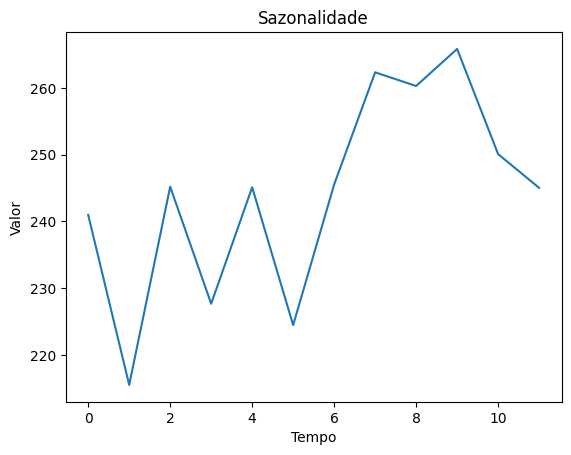

Sazonalidade
Sazonalidade              
0               240.981090
1               215.539900
2               245.202066
3               227.688361
4               245.118647
5               224.488539
6               245.532886
7               262.321346
8               260.276762
9               265.822767
10              250.083880
11              245.032321

In [32]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['Sazonalidade'] = df.index % 12
    monthly_means = df.groupby('Sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'Sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [33]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['Sazonalidade'].tolist()
    df_og['Sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

Unnamed: 0  Bahia - Preço Cimento  Bahia- custo m2 (R$)  \
0       2003-1               0.299858          10915.348400   
1       2003-2               0.301903          11028.218400   
2       2003-3               0.303709          11133.335807   
3       2003-4               0.305311          11215.137236   
4       2003-5               0.306860          11294.955512   
..         ...                    ...                   ...   
268     2002-8                    NaN                   NaN   
269     2002-9                    NaN                   NaN   
270    2002-10                    NaN                   NaN   
271    2002-11                    NaN                   NaN   
272    2002-12                    NaN                   NaN   

     Precipitação (mm/day)  Pressão Atmosférica (mB)  \
0                 1.604227               1007.701639   
1                 2.224533               1007.849476   
2                 2.312330               1008.259608   
3                 2.332765               1009.143887   
4                 2.225842               1010.005569   
..                     ...                       ...   
268               1.608320               1010.371607   
269               1.453784               1009.628033   
270               1.071670               1008.927909   
271               1.149319               1008.388051   
272               1.302823               1007.896538   

     Radiação Global - Dia (Kj/m²)  Temperatura do Ar - Bulbo Seco (°C)  \
0                      1669.734463                            26.973700   
1                      1568.727444                            26.728784   
2                      1452.272884                            26.305364   
3                      1359.230366                            25.788306   
4                      1291.737281                            25.189925   
..                             ...                                  ...   
268                    1488.966218                            24.817842   
269                    1569.704039                            25.399925   
270                    1667.519304                            26.035253   
271                    1694.210509                            26.573861   
272                    1700.542177                            26.944260   

     Temperatura de Ponto De Orvalho (°C)  Humidade Relativa do Ar (%)  \
0                               22.147525                    75.411587   
1                               22.241910                    76.966756   
2                               22.159668                    78.493126   
3                               21.728601                    78.801800   
4                               21.303605                    79.547467   
..                                    ...                          ...   
268                             20.666681                    78.229336   
269                             20.932220                    76.934612   
270                             21.204426                    75.331548   
271                             21.523948                    74.405966   
272                             21.882852                    74.400960   

     Velocidade do Vento (m/s)  Bahia - IDH Educacao  Bahia - IDH Longevidade  \
0                     2.004234              0.598394                 0.766362   
1                     1.726139              0.598795                 0.766745   
2                     1.462602              0.599196                 0.767127   
3                     1.217048              0.599597                 0.767509   
4                     1.031926              0.599998                 0.767892   
..                         ...                   ...                      ...   
268                   1.977754                   NaN                      NaN   
269                   2.093929                   NaN                      NaN   
270                   2.191347                   NaN   

In [34]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      139.997
1      111.865
2      159.603
3      142.063
4      137.144
        ...   
268        NaN
269        NaN
270        NaN
271        NaN
272        NaN
Name: Bahia - Consumo de Cimento (t), Length: 273, dtype: float64

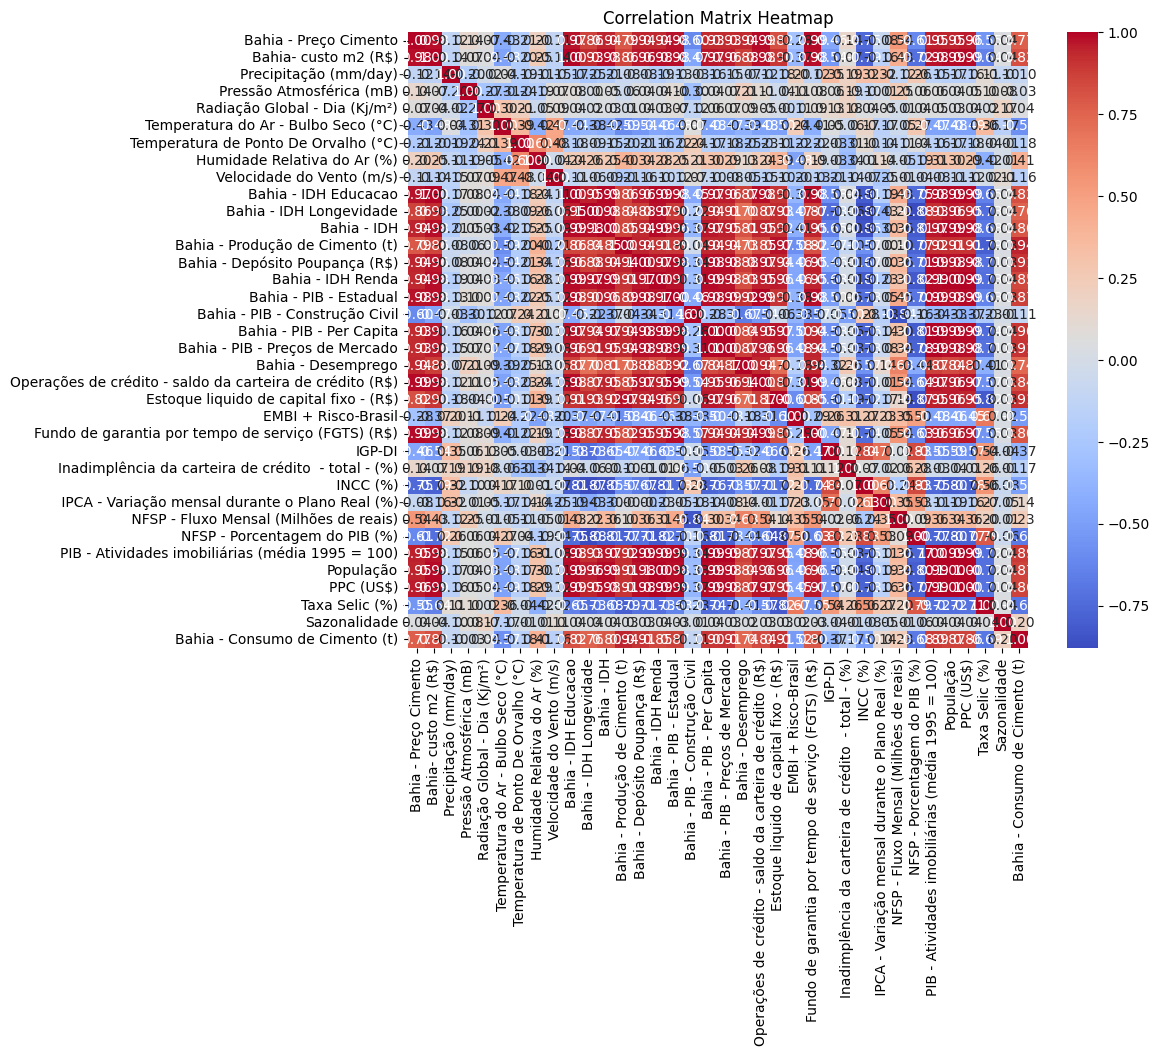

In [35]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [37]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

Feature           VIF
0                               Bahia - Preço Cimento  1.081891e+06
1                                Bahia- custo m2 (R$)  2.748305e+06
2                               Precipitação (mm/day)  7.884917e+01
3                            Pressão Atmosférica (mB)  4.042280e+06
4                       Radiação Global - Dia (Kj/m²)  7.126118e+02
5                 Temperatura do Ar - Bulbo Seco (°C)  2.375734e+04
6                Temperatura de Ponto De Orvalho (°C)  5.056837e+03
7                         Humidade Relativa do Ar (%)  2.999788e+04
8                           Velocidade do Vento (m/s)  4.949185e+02
9                                Bahia - IDH Educacao  1.127392e+09
10                            Bahia - IDH Longevidade  3.066340e+09
11                                        Bahia - IDH  4.329928e+09
12                    Bahia - Produção de Cimento (t)  1.095040e+05
13                     Bahia - Depósito Poupança (R$)  1.858352e+04
14                                  Bahia - IDH Renda  2.790354e+08
15                             Bahia - PIB - Estadual  1.259102e+08
16                     Bahia - PIB - Construção Civil  1.671186e+04
17                           Bahia - PIB - Per Capita  1.032671e+05
18                    Bahia - PIB - Preços de Mercado  2.982856e+09
19                                 Bahia - Desemprego  1.323061e+04
20  Operações de crédito - saldo da carteira de cr...  1.455295e+05
21             Estoque liquido de capital fixo - (R$)  1.069025e+08
22                                EMBI + Risco-Brasil  1.005640e+03
23  Fundo de garantia por tempo de serviço (FGTS) ...  1.988028e+03
24                                             IGP-DI  8.803124e+02
25  Inadimplência da carteira de crédito  - total ...  1.846773e+04
26                                           INCC (%)  4.081661e+03
27    IPCA - Variação mensal durante o Plano Real (%)  9.639153e+03
28             NFSP - Fluxo Mensal (Milhões de reais)  6.098906e+02
29                      NFSP - Porcentagem do PIB (%)  6.754862e+03
30   PIB - Atividades imobiliárias (média 1995 = 100)  6.928139e+05
31                                          População  2.066556e+05
32                                          PPC (US$)  8.460334e+05
33                                     Taxa Selic (%)  1.133161e+02
34                                       Sazonalidade  4.998903e+02

In [38]:
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 9


Bahia - Preço Cimento  Bahia- custo m2 (R$)  Precipitação (mm/day)  \
0                 0.299858          10915.348400               1.604227   
1                 0.301903          11028.218400               2.224533   
2                 0.303709          11133.335807               2.312330   
3                 0.305311          11215.137236               2.332765   
4                 0.306860          11294.955512               2.225842   
..                     ...                   ...                    ...   
175               0.476605          24167.020501               1.537428   
176               0.478697          24257.282126               1.715185   
177               0.480679          24345.838739               1.888699   
178               0.481471          24432.887826               1.788348   
179               0.482260          24518.433417               2.008483   

     Radiação Global - Dia (Kj/m²)  Temperatura do Ar - Bulbo Seco (°C)  \
0                      1669.734463                            26.973700   
1                      1568.727444                            26.728784   
2                      1452.272884                            26.305364   
3                      1359.230366                            25.788306   
4                      1291.737281                            25.189925   
..                             ...                                  ...   
175                    1418.281420                            24.686518   
176                    1490.406042                            25.138703   
177                    1558.871017                            25.697088   
178                    1591.633436                            26.156110   
179                    1617.584435                            26.560098   

     Temperatura de Ponto De Orvalho (°C)  Humidade Relativa do Ar (%)  \
0                               22.147525                    75.411587   
1                               22.241910                    76.966756   
2                               22.159668                    78.493126   
3                               21.728601                    78.801800   
4                               21.303605                    79.547467   
..                                    ...                          ...   
175                             20.094589                    76.227985   
176                             20.393141                    75.659901   
177                             20.758309                    74.930777   
178                             21.152716                    74.760722   
179                             21.441297                    74.349280   

     Velocidade do Vento (m/s)  Bahia - Produção de Cimento (t)  \
0                     2.004234                        39.798880   
1                     1.726139                        39.480034   
2                     1.462602                        39.400256   
3                     1.217048                        39.417185   
4                     1.031926                        39.479943   
..                         ...                              ...   
175                   1.593444                        91.995691   
176                   1.597502                        91.964124   
177                   1.560874                        92.171781   
178                   1.542429                        92.052788   
179                   1.523592                        92.190382   

     Bahia - Depósito Poupança (R$)  Bahia - PIB - Estadual  \
0                      7.782609e+06            1.317344e+08   
1                      7.827094e+06            1.318964e+08   
2                      7.871579e+06            1.320584e+08   
3                      7.916064e+06            1.322204e+08   
4                      7.960549e+06            1.323824e+08   
..                              ...                     ...   
175                    2.010533e+07            1.564800e+08   
176  

In [39]:
input_data = data.iloc[:split_index + 1,1:]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

Bahia- custo m2 (R$)  Precipitação (mm/day)  \
0               -1.679365              -0.018747   
1               -1.650551               1.217740   
2               -1.623716               1.392750   
3               -1.602833               1.433483   
4               -1.582457               1.220348   
..                    ...                    ...   
175              1.703597              -0.151900   
176              1.726639               0.202432   
177              1.749247               0.548307   
178              1.771469               0.348271   
179              1.793308               0.787077   

     Radiação Global - Dia (Kj/m²)  Temperatura do Ar - Bulbo Seco (°C)  \
0                         1.225595                             0.610311   
1                         0.705387                             0.404623   
2                         0.105622                             0.049022   
3                        -0.373566                            -0.385219   
4                        -0.721170                            -0.887757   
..                             ...                                  ...   
175                      -0.069441                            -1.310534   
176                       0.302016                            -0.930776   
177                       0.654625                            -0.461827   
178                       0.823358                            -0.076326   
179                       0.957011                             0.262956   

     Temperatura de Ponto De Orvalho (°C)  Humidade Relativa do Ar (%)  \
0                                0.008691                    -0.181672   
1                                0.039131                     0.129230   
2                                0.012607                     0.434375   
3                               -0.126416                     0.496084   
4                               -0.263481                     0.645154   
..                                    ...                          ...   
175                             -0.653400                    -0.018461   
176                             -0.557115                    -0.132030   
177                             -0.439345                    -0.277793   
178                             -0.312145                    -0.311790   
179                             -0.219075                    -0.394043   

     Velocidade do Vento (m/s)  Bahia - Produção de Cimento (t)  \
0                     1.337807                        -1.650237   
1                     0.455378                        -1.662829   
2                    -0.380852                        -1.665979   
3                    -1.160025                        -1.665311   
4                    -1.747436                        -1.662832   
..                         ...                              ...   
175                   0.034323                         0.411133   
176                   0.047198                         0.409887   
177                  -0.069026                         0.418087   
178                  -0.127553                         0.413388   
179                  -0.187326                         0.418822   

     Bahia - Depósito Poupança (R$)  Bahia - PIB - Estadual  \
0                         -1.532772               -1.646879   
1                         -1.522961               -1.627694   
2                         -1.513149               -1.608509   
3                         -1.503338               -1.589324   
4                         -1.493526               -1.570138   
..                              ...                     ...   
175                        1.185078                1.283512   
176                        1.204425                1.279927   
177                        1.223772                1.276342   
178                        1.243118                1.272758   
179                        1.262465                1.269173   

     Bahia - PIB - Construçã

In [40]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

Bahia- custo m2 (R$)  Precipitação (mm/day)  \
0               -1.679365              -0.018747   
1               -1.650551               1.217740   
2               -1.623716               1.392750   
3               -1.602833               1.433483   
4               -1.582457               1.220348   
..                    ...                    ...   
163              1.428503              -0.824761   
164              1.450155              -0.967080   
165              1.472497              -0.802545   
166              1.494794              -0.401380   
167              1.517367               0.100986   

     Radiação Global - Dia (Kj/m²)  Temperatura do Ar - Bulbo Seco (°C)  \
0                         1.225595                             0.610311   
1                         0.705387                             0.404623   
2                         0.105622                             0.049022   
3                        -0.373566                            -0.385219   
4                        -0.721170                            -0.887757   
..                             ...                                  ...   
163                       0.088610                            -0.639039   
164                       0.471697                            -0.343360   
165                       0.999680                             0.000672   
166                       1.099294                             0.229230   
167                       1.200185                             0.456238   

     Temperatura de Ponto De Orvalho (°C)  Humidade Relativa do Ar (%)  \
0                                0.008691                    -0.181672   
1                                0.039131                     0.129230   
2                                0.012607                     0.434375   
3                               -0.126416                     0.496084   
4                               -0.263481                     0.645154   
..                                    ...                          ...   
163                             -0.503765                    -0.296263   
164                             -0.425313                    -0.384261   
165                             -0.376653                    -0.583257   
166                             -0.340132                    -0.700735   
167                             -0.283678                    -0.772338   

     Velocidade do Vento (m/s)  Bahia - Produção de Cimento (t)  \
0                     1.337807                        -1.650237   
1                     0.455378                        -1.662829   
2                    -0.380852                        -1.665979   
3                    -1.160025                        -1.665311   
4                    -1.747436                        -1.662832   
..                         ...                              ...   
163                  -0.257511                         0.515788   
164                  -0.188812                         0.503986   
165                  -0.099226                         0.501383   
166                  -0.097607                         0.493451   
167                  -0.192067                         0.455306   

     Bahia - Depósito Poupança (R$)  Bahia - PIB - Estadual  \
0                         -1.532772               -1.646879   
1                         -1.522961               -1.627694   
2                         -1.513149               -1.608509   
3                         -1.503338               -1.589324   
4                         -1.493526               -1.570138   
..                              ...                     ...   
163                        0.987961                1.301773   
164                        1.000299                1.303139   
165                        1.012637                1.304505   
166                        1.024975                1.305871   
167                        1.037314                1.307237   

     Bahia - PIB - Construçã

In [41]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      139.997
1      111.865
2      159.603
3      142.063
4      137.144
        ...   
163    292.688
164    258.881
165    276.879
166    255.774
167    208.326
Name: Bahia - Consumo de Cimento (t), Length: 168, dtype: float64

In [42]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

Bahia- custo m2 (R$)  Precipitação (mm/day)  \
168              1.540582               0.325795   
169              1.563177               0.826977   
170              1.587829               0.683342   
171              1.612171               0.354218   
172              1.636265               0.103990   
173              1.658193              -0.328213   
174              1.680527              -0.276217   
175              1.703597              -0.151900   
176              1.726639               0.202432   
177              1.749247               0.548307   
178              1.771469               0.348271   
179              1.793308               0.787077   

     Radiação Global - Dia (Kj/m²)  Temperatura do Ar - Bulbo Seco (°C)  \
168                       1.001034                             0.513736   
169                       0.322915                             0.325873   
170                      -0.190761                             0.041336   
171                      -0.692303                            -0.466829   
172                      -0.861831                            -0.975142   
173                      -0.698489                            -1.344533   
174                      -0.405821                            -1.502265   
175                      -0.069441                            -1.310534   
176                       0.302016                            -0.930776   
177                       0.654625                            -0.461827   
178                       0.823358                            -0.076326   
179                       0.957011                             0.262956   

     Temperatura de Ponto De Orvalho (°C)  Humidade Relativa do Ar (%)  \
168                             -0.226925                    -0.672458   
169                             -0.182195                    -0.363678   
170                             -0.194919                    -0.117374   
171                             -0.318928                     0.052120   
172                             -0.486189                     0.104761   
173                             -0.622285                     0.098610   
174                             -0.706801                     0.023760   
175                             -0.653400                    -0.018461   
176                             -0.557115                    -0.132030   
177                             -0.439345                    -0.277793   
178                             -0.312145                    -0.311790   
179                             -0.219075                    -0.394043   

     Velocidade do Vento (m/s)  Bahia - Produção de Cimento (t)  \
168                  -0.277409                         0.456143   
169                  -0.359648                         0.449042   
170                  -0.413025                         0.447484   
171                  -0.168222                         0.429094   
172                  -0.089072                         0.434042   
173                   0.103677                         0.417492   
174                   0.217267                         0.413669   
175                   0.034323                         0.411133   
176                   0.047198                         0.409887   
177                  -0.069026                         0.418087   
178                  -0.127553                         0.413388   
179                  -0.187326                         0.418822   

     Bahia - Depósito Poupança (R$)  Bahia - PIB - Estadual  \
168                        1.049652                1.308603   
169                        1.068999                1.305019   
170                        1.088345                1.301434   
171                        1.107692                1.297850   
172                        1.127038                1.294265   
173                        1.146385                1.290681   
174                        1.165732                1.287096   
175          

In [43]:
# Alvo para teste
test_target = target_data.iloc[train_split - window_size:split_index + 1]
test_target

168    291.428
169    249.430
170    241.612
171    252.303
172    281.912
173    200.213
174    270.511
175    281.466
176    285.535
177    328.259
178    298.078
179    264.838
Name: Bahia - Consumo de Cimento (t), dtype: float64

In [44]:
# Rede neural feed-forward com optmizador Estocástico
def neural_network_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='tanh', kernel_regularizer=regularizers.l2(0.01), 
                              input_shape=(train_input.shape[1],)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='tanh', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(32, activation='tanh', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')   
    history = model.fit(train_input, 
                      train_target, 
                      epochs=10000,
                      validation_split=0.07,
                      callbacks=[early_stopping], 
                      verbose=want_verbose)
    return model, history

In [45]:
winner_seed = 2869505983

In [46]:
trained_model, history = neural_network_model(train_input, train_target, want_verbose=1, seed=winner_seed)
# 2869505983

Epoch 1/10000
5/5 [==============================] - 0s 21ms/step - loss: 69820.0234 - val_loss: 70315.8906
Epoch 2/10000
5/5 [==============================] - 0s 4ms/step - loss: 46104.9766 - val_loss: 129748.2109
Epoch 3/10000
5/5 [==============================] - 0s 4ms/step - loss: 35866.1094 - val_loss: 80693.9609
Epoch 4/10000
5/5 [==============================] - 0s 4ms/step - loss: 7577.9839 - val_loss: 8804.7656
Epoch 5/10000
5/5 [==============================] - 0s 4ms/step - loss: 1990.3107 - val_loss: 35900.0195
Epoch 6/10000
5/5 [==============================] - 0s 4ms/step - loss: 1471.0568 - val_loss: 4187.3525
Epoch 7/10000
5/5 [==============================] - 0s 4ms/step - loss: 1279.4983 - val_loss: 5581.7642
Epoch 8/10000
5/5 [==============================] - 0s 4ms/step - loss: 1375.6953 - val_loss: 5987.6733
Epoch 9/10000
5/5 [==============================] - 0s 4ms/step - loss: 1342.5588 - val_loss: 5361.2876
Epoch 10/10000
5/5 [==========================

Epoch 79/10000
5/5 [==============================] - 0s 4ms/step - loss: 661.4021 - val_loss: 1436.4674
Epoch 80/10000
5/5 [==============================] - 0s 4ms/step - loss: 635.8976 - val_loss: 1296.6649
Epoch 81/10000
5/5 [==============================] - 0s 5ms/step - loss: 574.4350 - val_loss: 1108.9714
Epoch 82/10000
5/5 [==============================] - 0s 5ms/step - loss: 573.4571 - val_loss: 1183.3706
Epoch 83/10000
5/5 [==============================] - 0s 4ms/step - loss: 601.7953 - val_loss: 1119.6265
Epoch 84/10000
5/5 [==============================] - 0s 4ms/step - loss: 544.6098 - val_loss: 1061.9907
Epoch 85/10000
5/5 [==============================] - 0s 4ms/step - loss: 542.7528 - val_loss: 972.4177
Epoch 86/10000
5/5 [==============================] - 0s 4ms/step - loss: 629.4579 - val_loss: 1839.3351
Epoch 87/10000
5/5 [==============================] - 0s 4ms/step - loss: 659.4589 - val_loss: 1110.5630
Epoch 88/10000
5/5 [==============================] - 0s

5/5 [==============================] - 0s 4ms/step - loss: 566.3336 - val_loss: 959.0905
Epoch 157/10000
5/5 [==============================] - 0s 5ms/step - loss: 611.4333 - val_loss: 975.9178
Epoch 158/10000
5/5 [==============================] - 0s 4ms/step - loss: 571.0471 - val_loss: 919.9586
Epoch 159/10000
5/5 [==============================] - 0s 4ms/step - loss: 631.3964 - val_loss: 1305.6537
Epoch 160/10000
5/5 [==============================] - 0s 4ms/step - loss: 603.9876 - val_loss: 1255.8228
Epoch 161/10000
5/5 [==============================] - 0s 4ms/step - loss: 654.3033 - val_loss: 1251.0074
Epoch 162/10000
5/5 [==============================] - 0s 4ms/step - loss: 629.6216 - val_loss: 1265.3641
Epoch 163/10000
5/5 [==============================] - 0s 4ms/step - loss: 586.0641 - val_loss: 1264.2401
Epoch 164/10000
5/5 [==============================] - 0s 4ms/step - loss: 564.5479 - val_loss: 1260.0583
Epoch 165/10000
5/5 [==============================] - 0s 5ms/ste

5/5 [==============================] - 0s 4ms/step - loss: 524.9658 - val_loss: 6917.8730
Epoch 234/10000
5/5 [==============================] - 0s 4ms/step - loss: 628.6402 - val_loss: 3920.9875
Epoch 235/10000
5/5 [==============================] - 0s 4ms/step - loss: 613.1327 - val_loss: 2336.2478
Epoch 236/10000
5/5 [==============================] - 0s 4ms/step - loss: 821.0266 - val_loss: 1463.8971
Epoch 237/10000
5/5 [==============================] - 0s 4ms/step - loss: 589.7863 - val_loss: 2453.8933
Epoch 238/10000
5/5 [==============================] - 0s 4ms/step - loss: 588.9720 - val_loss: 5874.2720
Epoch 239/10000
5/5 [==============================] - 0s 4ms/step - loss: 573.2722 - val_loss: 6226.8706
Epoch 240/10000
5/5 [==============================] - 0s 4ms/step - loss: 665.7901 - val_loss: 5216.1787
Epoch 241/10000
5/5 [==============================] - 0s 4ms/step - loss: 574.3077 - val_loss: 3727.3440
Epoch 242/10000
5/5 [==============================] - 0s 4ms/

5/5 [==============================] - 0s 4ms/step - loss: 534.3939 - val_loss: 2182.9746
Epoch 311/10000
5/5 [==============================] - 0s 4ms/step - loss: 496.1835 - val_loss: 2094.9331
Epoch 312/10000
5/5 [==============================] - 0s 4ms/step - loss: 497.2936 - val_loss: 2985.1565
Epoch 313/10000
5/5 [==============================] - 0s 4ms/step - loss: 489.6540 - val_loss: 3321.5608
Epoch 314/10000
5/5 [==============================] - 0s 4ms/step - loss: 547.7959 - val_loss: 5476.8765
Epoch 315/10000
5/5 [==============================] - 0s 4ms/step - loss: 519.2314 - val_loss: 5150.9233
Epoch 316/10000
5/5 [==============================] - 0s 4ms/step - loss: 601.3525 - val_loss: 5720.4858
Epoch 317/10000
5/5 [==============================] - 0s 4ms/step - loss: 564.5743 - val_loss: 6848.6992
Epoch 318/10000
5/5 [==============================] - 0s 4ms/step - loss: 546.7356 - val_loss: 6358.9336
Epoch 319/10000
5/5 [==============================] - 0s 4ms/

5/5 [==============================] - 0s 4ms/step - loss: 532.1728 - val_loss: 949.4583
Epoch 388/10000
5/5 [==============================] - 0s 4ms/step - loss: 558.2719 - val_loss: 954.3701
Epoch 389/10000
5/5 [==============================] - 0s 4ms/step - loss: 554.1235 - val_loss: 889.1240
Epoch 390/10000
5/5 [==============================] - 0s 4ms/step - loss: 577.1301 - val_loss: 993.4849
Epoch 391/10000
5/5 [==============================] - 0s 4ms/step - loss: 491.0864 - val_loss: 890.5555
Epoch 392/10000
5/5 [==============================] - 0s 4ms/step - loss: 506.1482 - val_loss: 1075.0886
Epoch 393/10000
5/5 [==============================] - 0s 5ms/step - loss: 516.0138 - val_loss: 1345.5798
Epoch 394/10000
5/5 [==============================] - 0s 4ms/step - loss: 587.9032 - val_loss: 1549.7491
Epoch 395/10000
5/5 [==============================] - 0s 4ms/step - loss: 610.6665 - val_loss: 1213.1038
Epoch 396/10000
5/5 [==============================] - 0s 4ms/step 

5/5 [==============================] - 0s 5ms/step - loss: 487.2395 - val_loss: 1097.6083
Epoch 465/10000
5/5 [==============================] - 0s 5ms/step - loss: 507.5973 - val_loss: 1788.3866
Epoch 466/10000
5/5 [==============================] - 0s 4ms/step - loss: 477.9910 - val_loss: 1421.8687
Epoch 467/10000
5/5 [==============================] - 0s 4ms/step - loss: 471.6234 - val_loss: 1194.0446
Epoch 468/10000
5/5 [==============================] - 0s 6ms/step - loss: 469.9705 - val_loss: 1119.9498
Epoch 469/10000
5/5 [==============================] - 0s 4ms/step - loss: 487.9735 - val_loss: 964.4079
Epoch 470/10000
5/5 [==============================] - 0s 4ms/step - loss: 475.4438 - val_loss: 1057.1885
Epoch 471/10000
5/5 [==============================] - 0s 4ms/step - loss: 453.0788 - val_loss: 1098.2499
Epoch 472/10000
5/5 [==============================] - 0s 4ms/step - loss: 449.5230 - val_loss: 982.9995
Epoch 473/10000
5/5 [==============================] - 0s 4ms/st

5/5 [==============================] - 0s 4ms/step - loss: 551.3235 - val_loss: 1560.7139
Epoch 542/10000
5/5 [==============================] - 0s 5ms/step - loss: 485.4824 - val_loss: 2072.2329
Epoch 543/10000
5/5 [==============================] - 0s 4ms/step - loss: 547.1531 - val_loss: 2349.0291
Epoch 544/10000
5/5 [==============================] - 0s 4ms/step - loss: 510.2436 - val_loss: 1599.4183
Epoch 545/10000
5/5 [==============================] - 0s 4ms/step - loss: 462.0126 - val_loss: 1069.1959
Epoch 546/10000
5/5 [==============================] - 0s 4ms/step - loss: 493.3175 - val_loss: 1147.7882
Epoch 547/10000
5/5 [==============================] - 0s 4ms/step - loss: 494.9131 - val_loss: 1046.2566
Epoch 548/10000
5/5 [==============================] - 0s 4ms/step - loss: 475.7773 - val_loss: 1026.0756
Epoch 549/10000
5/5 [==============================] - 0s 4ms/step - loss: 470.4975 - val_loss: 1080.2493
Epoch 550/10000
5/5 [==============================] - 0s 4ms/

5/5 [==============================] - 0s 5ms/step - loss: 450.2918 - val_loss: 1248.7592
Epoch 619/10000
5/5 [==============================] - 0s 5ms/step - loss: 443.4487 - val_loss: 1076.0006
Epoch 620/10000
5/5 [==============================] - 0s 6ms/step - loss: 447.5133 - val_loss: 1181.9556
Epoch 621/10000
5/5 [==============================] - 0s 5ms/step - loss: 458.0602 - val_loss: 1221.4220
Epoch 622/10000
5/5 [==============================] - 0s 4ms/step - loss: 549.3519 - val_loss: 1285.8516
Epoch 623/10000
5/5 [==============================] - 0s 5ms/step - loss: 494.1647 - val_loss: 1338.1813
Epoch 624/10000
5/5 [==============================] - 0s 5ms/step - loss: 450.0706 - val_loss: 1538.2340
Epoch 625/10000
5/5 [==============================] - 0s 4ms/step - loss: 457.4273 - val_loss: 1234.5911
Epoch 626/10000
5/5 [==============================] - 0s 4ms/step - loss: 474.2181 - val_loss: 1354.0013
Epoch 627/10000
5/5 [==============================] - 0s 5ms/

Epoch 696/10000
5/5 [==============================] - 0s 4ms/step - loss: 479.9553 - val_loss: 1030.1895
Epoch 697/10000
5/5 [==============================] - 0s 4ms/step - loss: 445.9669 - val_loss: 1004.5079
Epoch 698/10000
5/5 [==============================] - 0s 4ms/step - loss: 468.8143 - val_loss: 1419.5941
Epoch 699/10000
5/5 [==============================] - 0s 5ms/step - loss: 459.9063 - val_loss: 869.8273
Epoch 700/10000
5/5 [==============================] - 0s 4ms/step - loss: 464.8862 - val_loss: 867.6468
Epoch 701/10000
5/5 [==============================] - 0s 4ms/step - loss: 444.1601 - val_loss: 916.2832
Epoch 702/10000
5/5 [==============================] - 0s 4ms/step - loss: 451.5945 - val_loss: 865.8380
Epoch 703/10000
5/5 [==============================] - 0s 4ms/step - loss: 476.5589 - val_loss: 1254.4264
Epoch 704/10000
5/5 [==============================] - 0s 4ms/step - loss: 474.8740 - val_loss: 1098.8947
Epoch 705/10000
5/5 [=============================

5/5 [==============================] - 0s 4ms/step - loss: 465.2638 - val_loss: 1052.8824
Epoch 774/10000
5/5 [==============================] - 0s 4ms/step - loss: 472.6611 - val_loss: 1191.2366
Epoch 775/10000
5/5 [==============================] - 0s 4ms/step - loss: 432.6024 - val_loss: 1132.8464
Epoch 776/10000
5/5 [==============================] - 0s 4ms/step - loss: 399.1902 - val_loss: 921.9333
Epoch 777/10000
5/5 [==============================] - 0s 4ms/step - loss: 454.5009 - val_loss: 1072.4402
Epoch 778/10000
5/5 [==============================] - 0s 4ms/step - loss: 434.7617 - val_loss: 909.7089
Epoch 779/10000
5/5 [==============================] - 0s 4ms/step - loss: 432.9567 - val_loss: 905.9431
Epoch 780/10000
5/5 [==============================] - 0s 4ms/step - loss: 427.7635 - val_loss: 1117.0454
Epoch 781/10000
5/5 [==============================] - 0s 4ms/step - loss: 465.0044 - val_loss: 1273.5415
Epoch 782/10000
5/5 [==============================] - 0s 4ms/ste

5/5 [==============================] - 0s 4ms/step - loss: 456.4797 - val_loss: 1093.3567
Epoch 851/10000
5/5 [==============================] - 0s 4ms/step - loss: 448.3730 - val_loss: 1128.0305
Epoch 852/10000
5/5 [==============================] - 0s 4ms/step - loss: 442.6119 - val_loss: 1129.3884
Epoch 853/10000
5/5 [==============================] - 0s 4ms/step - loss: 458.3381 - val_loss: 1152.8392
Epoch 854/10000
5/5 [==============================] - 0s 4ms/step - loss: 424.1995 - val_loss: 1145.2936
Epoch 855/10000
5/5 [==============================] - 0s 4ms/step - loss: 436.7906 - val_loss: 1322.3901
Epoch 856/10000
5/5 [==============================] - 0s 4ms/step - loss: 442.4099 - val_loss: 1308.4700
Epoch 857/10000
5/5 [==============================] - 0s 4ms/step - loss: 431.0833 - val_loss: 1321.5828
Epoch 858/10000
5/5 [==============================] - 0s 4ms/step - loss: 450.0566 - val_loss: 1336.4255
Epoch 859/10000
5/5 [==============================] - 0s 5ms/

5/5 [==============================] - 0s 4ms/step - loss: 422.1590 - val_loss: 1035.1450
Epoch 928/10000
5/5 [==============================] - 0s 4ms/step - loss: 372.4521 - val_loss: 979.4684
Epoch 929/10000
5/5 [==============================] - 0s 5ms/step - loss: 421.7147 - val_loss: 1073.8918
Epoch 930/10000
5/5 [==============================] - 0s 4ms/step - loss: 401.5305 - val_loss: 959.6321
Epoch 931/10000
5/5 [==============================] - 0s 4ms/step - loss: 399.2808 - val_loss: 939.1335
Epoch 932/10000
5/5 [==============================] - 0s 4ms/step - loss: 393.6591 - val_loss: 1093.6218
Epoch 933/10000
5/5 [==============================] - 0s 4ms/step - loss: 390.8448 - val_loss: 973.2131
Epoch 934/10000
5/5 [==============================] - 0s 4ms/step - loss: 401.7372 - val_loss: 985.9199
Epoch 935/10000
5/5 [==============================] - 0s 4ms/step - loss: 391.2404 - val_loss: 970.5193
Epoch 936/10000
5/5 [==============================] - 0s 4ms/step -

5/5 [==============================] - 0s 4ms/step - loss: 441.0783 - val_loss: 1624.1704
Epoch 1005/10000
5/5 [==============================] - 0s 4ms/step - loss: 419.5799 - val_loss: 1760.8423
Epoch 1006/10000
5/5 [==============================] - 0s 4ms/step - loss: 399.0688 - val_loss: 1565.6251
Epoch 1007/10000
5/5 [==============================] - 0s 4ms/step - loss: 387.1819 - val_loss: 1744.3097
Epoch 1008/10000
5/5 [==============================] - 0s 4ms/step - loss: 421.1354 - val_loss: 1702.8334
Epoch 1009/10000
5/5 [==============================] - 0s 4ms/step - loss: 385.0298 - val_loss: 1908.1127
Epoch 1010/10000
5/5 [==============================] - 0s 4ms/step - loss: 421.6505 - val_loss: 1514.1968
Epoch 1011/10000
5/5 [==============================] - 0s 4ms/step - loss: 415.7812 - val_loss: 1189.4409
Epoch 1012/10000
5/5 [==============================] - 0s 4ms/step - loss: 427.8156 - val_loss: 1237.0437
Epoch 1013/10000
5/5 [==============================] 

Epoch 1081/10000
5/5 [==============================] - 0s 4ms/step - loss: 434.2431 - val_loss: 1923.9076
Epoch 1082/10000
5/5 [==============================] - 0s 4ms/step - loss: 422.5961 - val_loss: 1917.6886
Epoch 1083/10000
5/5 [==============================] - 0s 4ms/step - loss: 423.5532 - val_loss: 1915.4014
Epoch 1084/10000
5/5 [==============================] - 0s 4ms/step - loss: 444.3886 - val_loss: 1645.3239
Epoch 1085/10000
5/5 [==============================] - 0s 4ms/step - loss: 373.5421 - val_loss: 2018.6940
Epoch 1086/10000
5/5 [==============================] - 0s 4ms/step - loss: 409.6475 - val_loss: 866.6082
Epoch 1087/10000
5/5 [==============================] - 0s 4ms/step - loss: 389.1216 - val_loss: 959.1125
Epoch 1088/10000
5/5 [==============================] - 0s 4ms/step - loss: 411.8247 - val_loss: 908.3500
Epoch 1089/10000
5/5 [==============================] - 0s 4ms/step - loss: 422.3010 - val_loss: 893.3914
Epoch 1090/10000
5/5 [===================

5/5 [==============================] - 0s 4ms/step - loss: 438.4964 - val_loss: 887.5444
Epoch 1158/10000
5/5 [==============================] - 0s 4ms/step - loss: 387.1650 - val_loss: 908.2971
Epoch 1159/10000
5/5 [==============================] - 0s 4ms/step - loss: 378.4319 - val_loss: 894.1141
Epoch 1160/10000
5/5 [==============================] - 0s 4ms/step - loss: 395.2785 - val_loss: 884.7889
Epoch 1161/10000
5/5 [==============================] - 0s 4ms/step - loss: 375.7769 - val_loss: 893.8644
Epoch 1162/10000
5/5 [==============================] - 0s 4ms/step - loss: 393.0661 - val_loss: 830.4272
Epoch 1163/10000
5/5 [==============================] - 0s 4ms/step - loss: 366.0379 - val_loss: 1035.2573
Epoch 1164/10000
5/5 [==============================] - 0s 4ms/step - loss: 373.1540 - val_loss: 913.1519
Epoch 1165/10000
5/5 [==============================] - 0s 4ms/step - loss: 391.2564 - val_loss: 1135.2483
Epoch 1166/10000
5/5 [==============================] - 0s 4m

Epoch 1234/10000
5/5 [==============================] - 0s 4ms/step - loss: 391.8108 - val_loss: 1572.0228
Epoch 1235/10000
5/5 [==============================] - 0s 4ms/step - loss: 374.3098 - val_loss: 1458.6195
Epoch 1236/10000
5/5 [==============================] - 0s 4ms/step - loss: 338.9545 - val_loss: 1371.2340
Epoch 1237/10000
5/5 [==============================] - 0s 4ms/step - loss: 332.2466 - val_loss: 1675.9742
Epoch 1238/10000
5/5 [==============================] - 0s 4ms/step - loss: 344.5258 - val_loss: 1536.2417
Epoch 1239/10000
5/5 [==============================] - 0s 4ms/step - loss: 362.5264 - val_loss: 1528.9586
Epoch 1240/10000
5/5 [==============================] - 0s 4ms/step - loss: 362.2020 - val_loss: 1400.1637
Epoch 1241/10000
5/5 [==============================] - 0s 4ms/step - loss: 358.4754 - val_loss: 1541.7760
Epoch 1242/10000
5/5 [==============================] - 0s 4ms/step - loss: 382.5124 - val_loss: 1212.1931
Epoch 1243/10000
5/5 [===============

5/5 [==============================] - 0s 4ms/step - loss: 345.5848 - val_loss: 1120.5541
Epoch 1311/10000
5/5 [==============================] - 0s 4ms/step - loss: 372.2466 - val_loss: 1246.8967
Epoch 1312/10000
5/5 [==============================] - 0s 4ms/step - loss: 377.6650 - val_loss: 1294.3562
Epoch 1313/10000
5/5 [==============================] - 0s 4ms/step - loss: 356.9303 - val_loss: 1019.0740
Epoch 1314/10000
5/5 [==============================] - 0s 4ms/step - loss: 356.0453 - val_loss: 915.3179
Epoch 1315/10000
5/5 [==============================] - 0s 4ms/step - loss: 382.2826 - val_loss: 964.5965
Epoch 1316/10000
5/5 [==============================] - 0s 4ms/step - loss: 354.8301 - val_loss: 973.9998
Epoch 1317/10000
5/5 [==============================] - 0s 4ms/step - loss: 377.7926 - val_loss: 898.9277
Epoch 1318/10000
5/5 [==============================] - 0s 4ms/step - loss: 338.6986 - val_loss: 874.0342
Epoch 1319/10000
5/5 [==============================] - 0s 

5/5 [==============================] - 0s 4ms/step - loss: 359.7737 - val_loss: 765.6487
Epoch 1388/10000
5/5 [==============================] - 0s 4ms/step - loss: 339.6960 - val_loss: 827.5593
Epoch 1389/10000
5/5 [==============================] - 0s 4ms/step - loss: 345.3096 - val_loss: 764.4790
Epoch 1390/10000
5/5 [==============================] - 0s 4ms/step - loss: 357.9953 - val_loss: 867.0911
Epoch 1391/10000
5/5 [==============================] - 0s 4ms/step - loss: 316.4911 - val_loss: 847.0605
Epoch 1392/10000
5/5 [==============================] - 0s 4ms/step - loss: 334.6428 - val_loss: 777.6731
Epoch 1393/10000
5/5 [==============================] - 0s 4ms/step - loss: 327.0097 - val_loss: 1008.5949
Epoch 1394/10000
5/5 [==============================] - 0s 4ms/step - loss: 359.9804 - val_loss: 887.9695
Epoch 1395/10000
5/5 [==============================] - 0s 4ms/step - loss: 359.9663 - val_loss: 858.1078
Epoch 1396/10000
5/5 [==============================] - 0s 4ms

5/5 [==============================] - 0s 4ms/step - loss: 334.3708 - val_loss: 948.7199
Epoch 1465/10000
5/5 [==============================] - 0s 4ms/step - loss: 353.2599 - val_loss: 819.8817
Epoch 1466/10000
5/5 [==============================] - 0s 4ms/step - loss: 337.0867 - val_loss: 784.4211
Epoch 1467/10000
5/5 [==============================] - 0s 4ms/step - loss: 362.0142 - val_loss: 824.3240
Epoch 1468/10000
5/5 [==============================] - 0s 4ms/step - loss: 323.2523 - val_loss: 821.8362
Epoch 1469/10000
5/5 [==============================] - 0s 4ms/step - loss: 353.0974 - val_loss: 723.4312
Epoch 1470/10000
5/5 [==============================] - 0s 4ms/step - loss: 363.2896 - val_loss: 896.9090
Epoch 1471/10000
5/5 [==============================] - 0s 4ms/step - loss: 390.7246 - val_loss: 858.2567
Epoch 1472/10000
5/5 [==============================] - 0s 4ms/step - loss: 357.9848 - val_loss: 859.5872
Epoch 1473/10000
5/5 [==============================] - 0s 4ms/

5/5 [==============================] - 0s 4ms/step - loss: 391.9962 - val_loss: 813.4074
Epoch 1542/10000
5/5 [==============================] - 0s 4ms/step - loss: 366.0255 - val_loss: 817.4670
Epoch 1543/10000
5/5 [==============================] - 0s 4ms/step - loss: 382.1366 - val_loss: 810.9894
Epoch 1544/10000
5/5 [==============================] - 0s 4ms/step - loss: 380.7710 - val_loss: 828.3308
Epoch 1545/10000
5/5 [==============================] - 0s 4ms/step - loss: 373.3521 - val_loss: 830.4684
Epoch 1546/10000
5/5 [==============================] - 0s 4ms/step - loss: 370.3582 - val_loss: 788.3159
Epoch 1547/10000
5/5 [==============================] - 0s 4ms/step - loss: 355.3620 - val_loss: 714.9929
Epoch 1548/10000
5/5 [==============================] - 0s 4ms/step - loss: 362.8459 - val_loss: 795.0617
Epoch 1549/10000
5/5 [==============================] - 0s 4ms/step - loss: 357.9819 - val_loss: 769.3525
Epoch 1550/10000
5/5 [==============================] - 0s 4ms/

5/5 [==============================] - 0s 4ms/step - loss: 382.7232 - val_loss: 747.9709
Epoch 1619/10000
5/5 [==============================] - 0s 4ms/step - loss: 388.4085 - val_loss: 755.4773
Epoch 1620/10000
5/5 [==============================] - 0s 4ms/step - loss: 400.9980 - val_loss: 747.3005
Epoch 1621/10000
5/5 [==============================] - 0s 4ms/step - loss: 382.0439 - val_loss: 747.2845
Epoch 1622/10000
5/5 [==============================] - 0s 4ms/step - loss: 378.1240 - val_loss: 743.5150
Epoch 1623/10000
5/5 [==============================] - 0s 4ms/step - loss: 376.8405 - val_loss: 839.9225
Epoch 1624/10000
5/5 [==============================] - 0s 4ms/step - loss: 374.5363 - val_loss: 834.8807
Epoch 1625/10000
5/5 [==============================] - 0s 4ms/step - loss: 393.6857 - val_loss: 732.4083
Epoch 1626/10000
5/5 [==============================] - 0s 4ms/step - loss: 363.3333 - val_loss: 766.7746
Epoch 1627/10000
5/5 [==============================] - 0s 4ms/

5/5 [==============================] - 0s 4ms/step - loss: 397.1439 - val_loss: 707.1877
Epoch 1696/10000
5/5 [==============================] - 0s 4ms/step - loss: 380.9052 - val_loss: 705.2046
Epoch 1697/10000
5/5 [==============================] - 0s 4ms/step - loss: 409.6503 - val_loss: 714.0883
Epoch 1698/10000
5/5 [==============================] - 0s 4ms/step - loss: 409.6924 - val_loss: 700.1574
Epoch 1699/10000
5/5 [==============================] - 0s 4ms/step - loss: 375.6696 - val_loss: 746.9705
Epoch 1700/10000
5/5 [==============================] - 0s 4ms/step - loss: 348.6542 - val_loss: 739.7547
Epoch 1701/10000
5/5 [==============================] - 0s 4ms/step - loss: 403.4542 - val_loss: 866.7136
Epoch 1702/10000
5/5 [==============================] - 0s 4ms/step - loss: 367.0401 - val_loss: 863.7769
Epoch 1703/10000
5/5 [==============================] - 0s 4ms/step - loss: 409.1586 - val_loss: 734.2296
Epoch 1704/10000
5/5 [==============================] - 0s 4ms/

5/5 [==============================] - 0s 4ms/step - loss: 406.3714 - val_loss: 886.3909
Epoch 1773/10000
5/5 [==============================] - 0s 4ms/step - loss: 396.2465 - val_loss: 778.8624
Epoch 1774/10000
5/5 [==============================] - 0s 4ms/step - loss: 394.4559 - val_loss: 810.4023
Epoch 1775/10000
5/5 [==============================] - 0s 4ms/step - loss: 362.6882 - val_loss: 904.5423
Epoch 1776/10000
5/5 [==============================] - 0s 4ms/step - loss: 390.7893 - val_loss: 855.6981
Epoch 1777/10000
5/5 [==============================] - 0s 4ms/step - loss: 394.5145 - val_loss: 849.8096
Epoch 1778/10000
5/5 [==============================] - 0s 4ms/step - loss: 390.0944 - val_loss: 874.9277
Epoch 1779/10000
5/5 [==============================] - 0s 4ms/step - loss: 411.2271 - val_loss: 816.7009
Epoch 1780/10000
5/5 [==============================] - 0s 4ms/step - loss: 374.9872 - val_loss: 855.3010
Epoch 1781/10000
5/5 [==============================] - 0s 4ms/

5/5 [==============================] - 0s 4ms/step - loss: 362.5491 - val_loss: 1021.0286
Epoch 1850/10000
5/5 [==============================] - 0s 4ms/step - loss: 376.6404 - val_loss: 1081.7073
Epoch 1851/10000
5/5 [==============================] - 0s 4ms/step - loss: 342.1867 - val_loss: 1072.0641
Epoch 1852/10000
5/5 [==============================] - 0s 4ms/step - loss: 361.9650 - val_loss: 1066.1086
Epoch 1853/10000
5/5 [==============================] - 0s 4ms/step - loss: 378.0630 - val_loss: 1071.2178
Epoch 1854/10000
5/5 [==============================] - 0s 4ms/step - loss: 386.2307 - val_loss: 1083.1478
Epoch 1855/10000
5/5 [==============================] - 0s 4ms/step - loss: 374.4374 - val_loss: 948.0949
Epoch 1856/10000
5/5 [==============================] - 0s 4ms/step - loss: 354.1331 - val_loss: 943.0262
Epoch 1857/10000
5/5 [==============================] - 0s 4ms/step - loss: 343.9214 - val_loss: 956.9243
Epoch 1858/10000
5/5 [==============================] - 0

5/5 [==============================] - 0s 4ms/step - loss: 346.3307 - val_loss: 1023.3817
Epoch 1927/10000
5/5 [==============================] - 0s 4ms/step - loss: 345.1201 - val_loss: 908.9612
Epoch 1928/10000
5/5 [==============================] - 0s 4ms/step - loss: 338.9235 - val_loss: 984.2952
Epoch 1929/10000
5/5 [==============================] - 0s 4ms/step - loss: 335.4154 - val_loss: 1091.8766
Epoch 1930/10000
5/5 [==============================] - 0s 4ms/step - loss: 327.2731 - val_loss: 1146.5150
Epoch 1931/10000
5/5 [==============================] - 0s 4ms/step - loss: 339.9303 - val_loss: 1123.7256
Epoch 1932/10000
5/5 [==============================] - 0s 4ms/step - loss: 367.2879 - val_loss: 1125.4344
Epoch 1933/10000
5/5 [==============================] - 0s 4ms/step - loss: 347.4966 - val_loss: 1127.6744
Epoch 1934/10000
5/5 [==============================] - 0s 4ms/step - loss: 379.4957 - val_loss: 962.9819
Epoch 1935/10000
5/5 [==============================] - 0

Epoch 2003/10000
5/5 [==============================] - 0s 4ms/step - loss: 319.2749 - val_loss: 966.1062
Epoch 2004/10000
5/5 [==============================] - 0s 4ms/step - loss: 347.2578 - val_loss: 1083.7136
Epoch 2005/10000
5/5 [==============================] - 0s 4ms/step - loss: 347.5461 - val_loss: 971.6809
Epoch 2006/10000
5/5 [==============================] - 0s 4ms/step - loss: 332.5826 - val_loss: 1065.8336
Epoch 2007/10000
5/5 [==============================] - 0s 4ms/step - loss: 344.3851 - val_loss: 1083.4449
Epoch 2008/10000
5/5 [==============================] - 0s 4ms/step - loss: 328.0405 - val_loss: 1006.0691
Epoch 2009/10000
5/5 [==============================] - 0s 5ms/step - loss: 350.0760 - val_loss: 1076.4453
Epoch 2010/10000
5/5 [==============================] - 0s 5ms/step - loss: 312.0956 - val_loss: 1120.1428
Epoch 2011/10000
5/5 [==============================] - 0s 5ms/step - loss: 332.8929 - val_loss: 1103.0347
Epoch 2012/10000
5/5 [=================

5/5 [==============================] - 0s 4ms/step - loss: 315.8937 - val_loss: 985.0933
Epoch 2080/10000
5/5 [==============================] - 0s 4ms/step - loss: 330.5943 - val_loss: 879.5198
Epoch 2081/10000
5/5 [==============================] - 0s 4ms/step - loss: 313.1555 - val_loss: 860.8815
Epoch 2082/10000
5/5 [==============================] - 0s 4ms/step - loss: 309.8004 - val_loss: 999.0637
Epoch 2083/10000
5/5 [==============================] - 0s 4ms/step - loss: 328.1531 - val_loss: 949.0086
Epoch 2084/10000
5/5 [==============================] - 0s 4ms/step - loss: 331.3482 - val_loss: 982.1502
Epoch 2085/10000
5/5 [==============================] - 0s 4ms/step - loss: 319.9066 - val_loss: 1002.3870
Epoch 2086/10000
5/5 [==============================] - 0s 4ms/step - loss: 353.2025 - val_loss: 809.3215
Epoch 2087/10000
5/5 [==============================] - 0s 4ms/step - loss: 329.4595 - val_loss: 817.3065
Epoch 2088/10000
5/5 [==============================] - 0s 4ms

In [47]:
trained_model.save('model_ba.keras')

In [55]:
def f(X):
    model = tf.keras.models.load_model('model_ba.keras')
    return model.predict(X)

def shap_explainer(train_input, test_input, test_target):
    explainer = shap.KernelExplainer(f, pd.DataFrame(np.zeros((1, len(train_input.columns.tolist()))), columns=test_input.columns))
    shap_values = explainer.shap_values(test_input)
    exp = shap.Explanation(shap_values[0], explainer.expected_value, test_input, feature_names=test_input.columns)
    display(shap.waterfall_plot(exp[0]))
#     display(shap.summary_plot(shap_values, features=test_input))
    display(shap.decision_plot(test_target, shap_values[0], test_input))
    return shap_values[0][0], explainer

def mae_mape_calculator(model, train_input, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        input_i = test_input[i:i+1]
        prediction = model.predict(input_i)
        target = test_target.iloc[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        info = [f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]]
        results_data.append(info)
        shap_calc_values, exp = shap_explainer(train_input, input_i, target)
        display(info)

       

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 527us/step


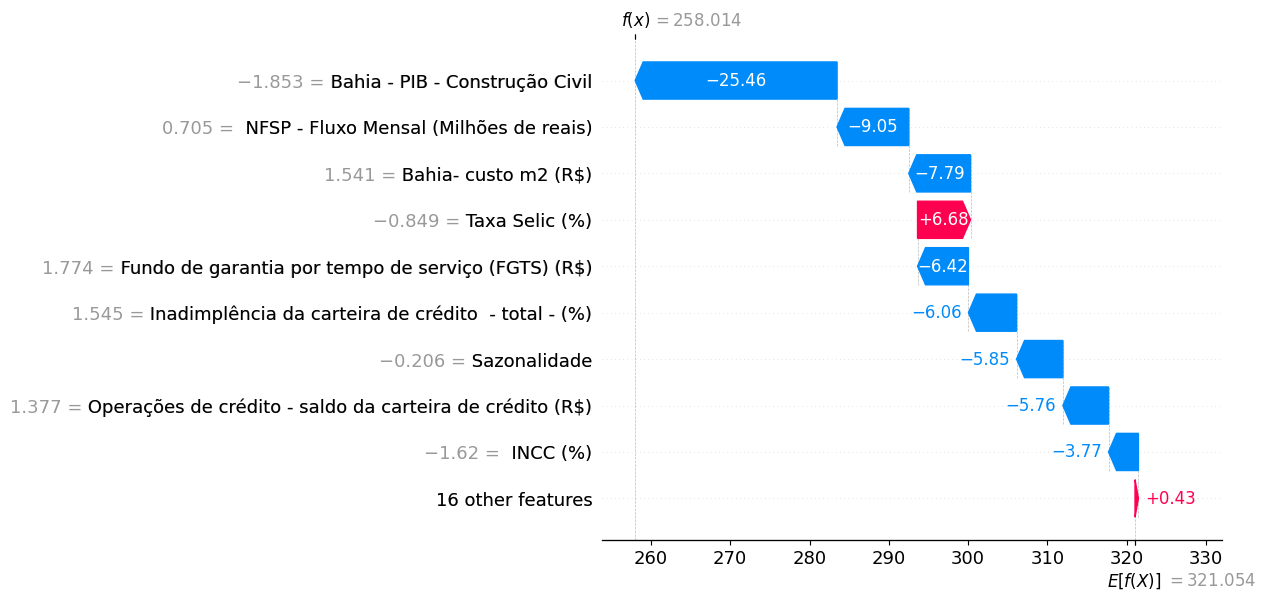

None

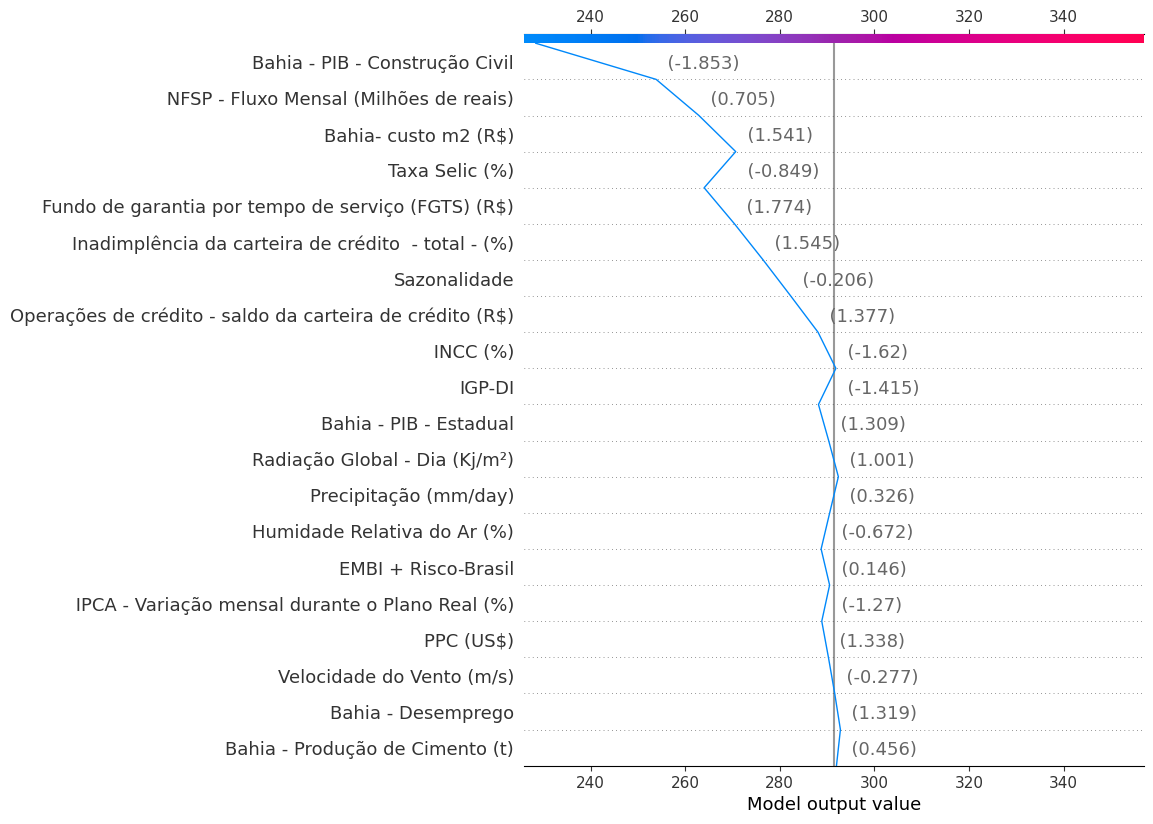

None

['Month-1', 258.01416, 291.428, 33.41385]

1/1 [==============================] - 0s 30ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 521us/step


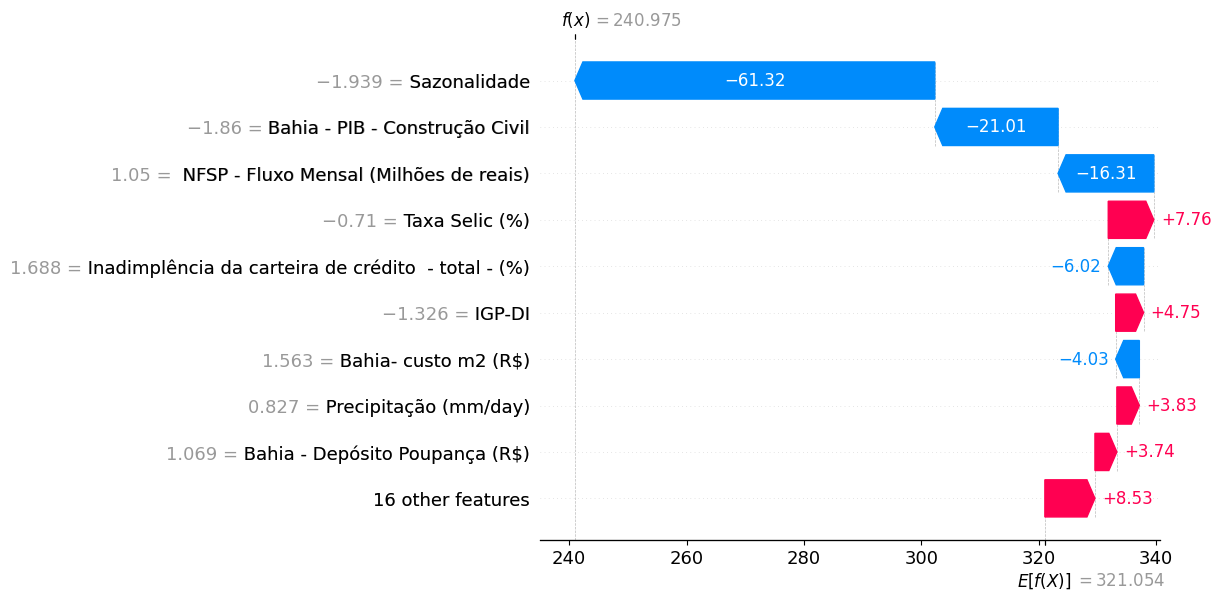

None

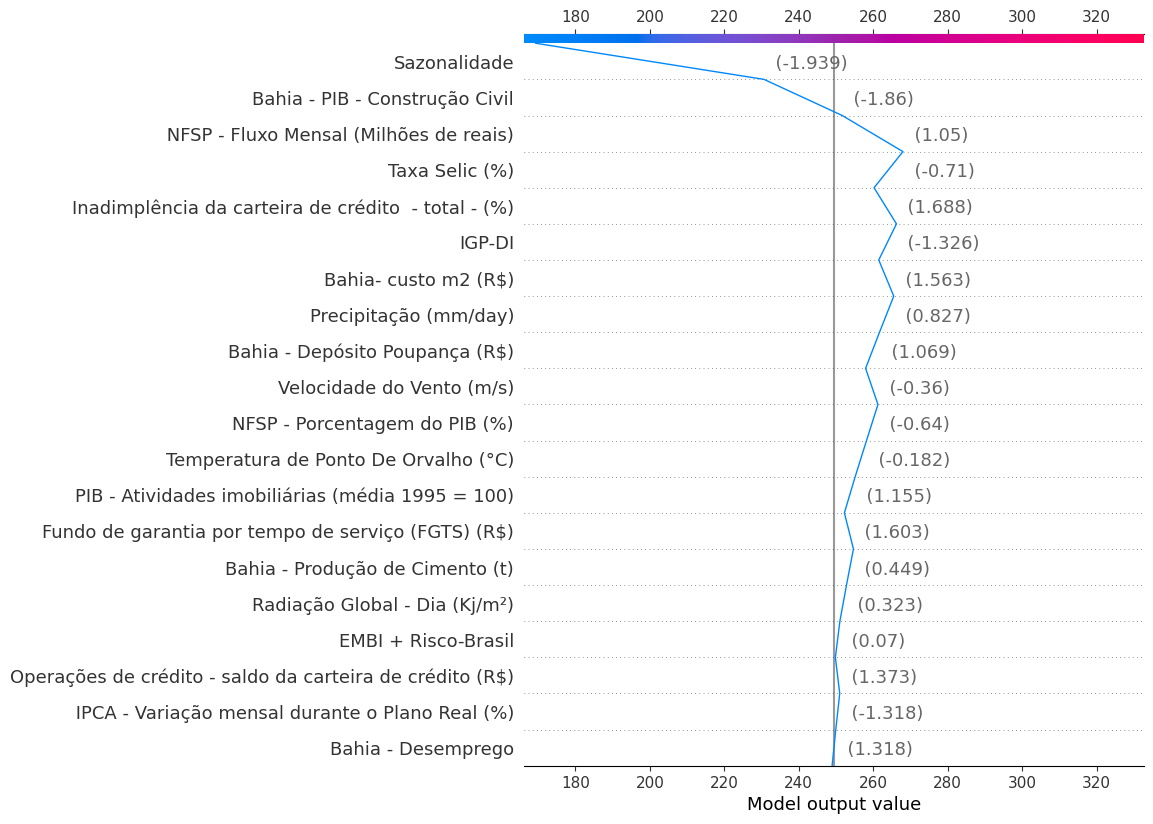

None

['Month-2', 240.97466, 249.43, 8.455338]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 512us/step


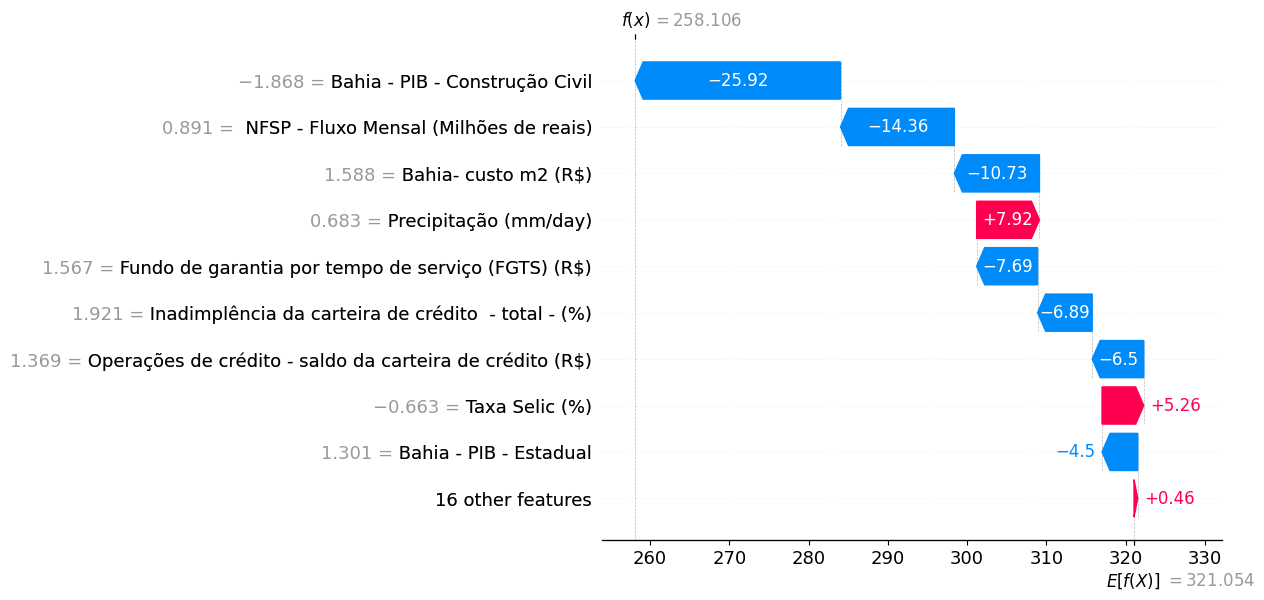

None

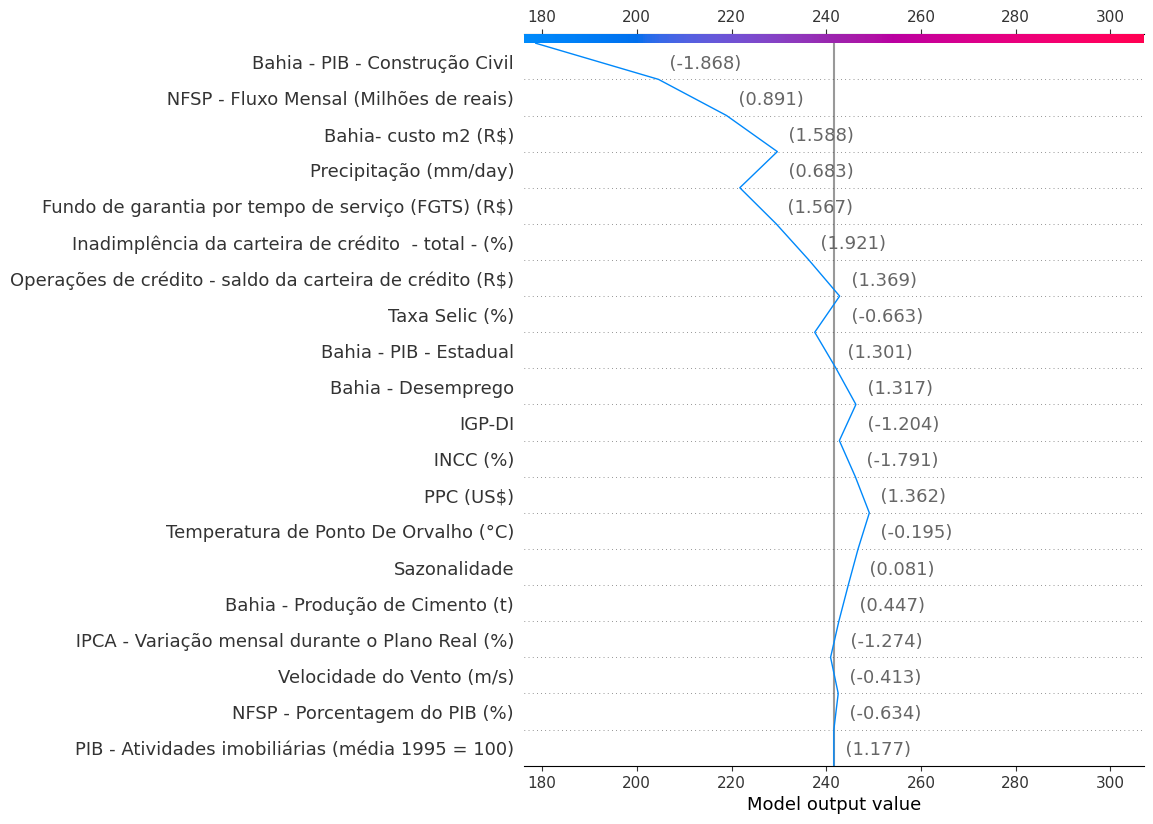

None

['Month-3', 258.1061, 241.612, 16.49411]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 565us/step


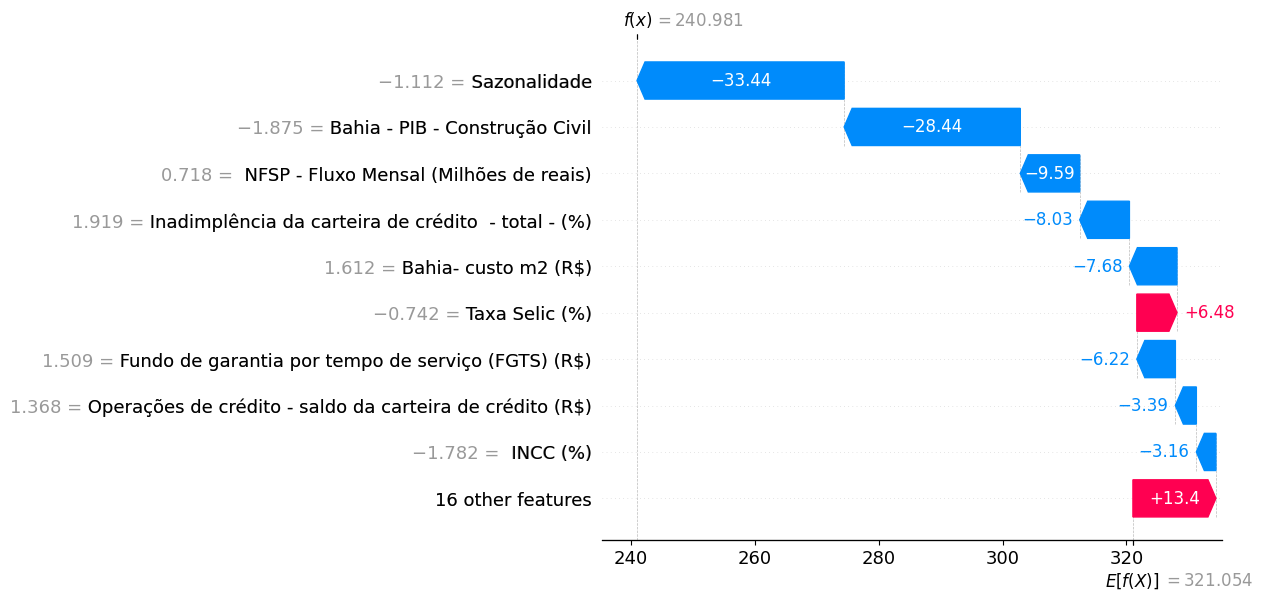

None

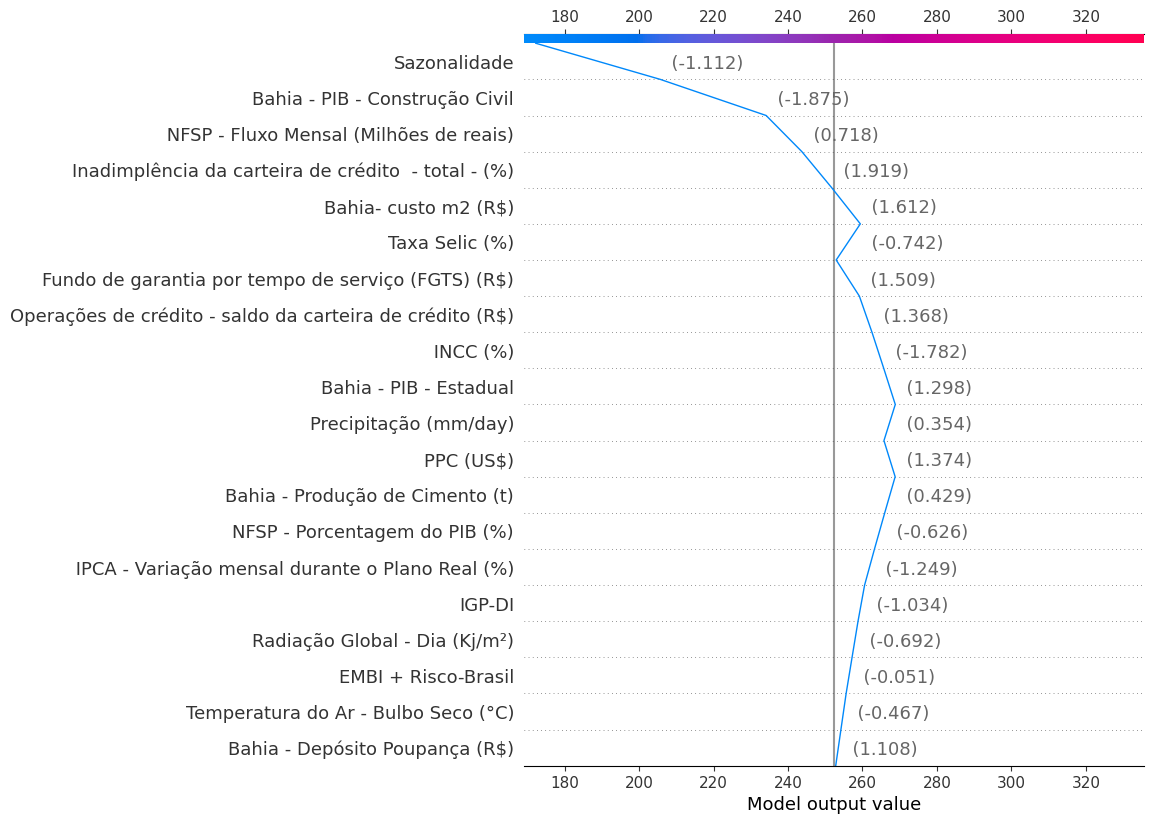

None

['Month-4', 240.98091, 252.303, 11.3220825]

1/1 [==============================] - 0s 34ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 525us/step


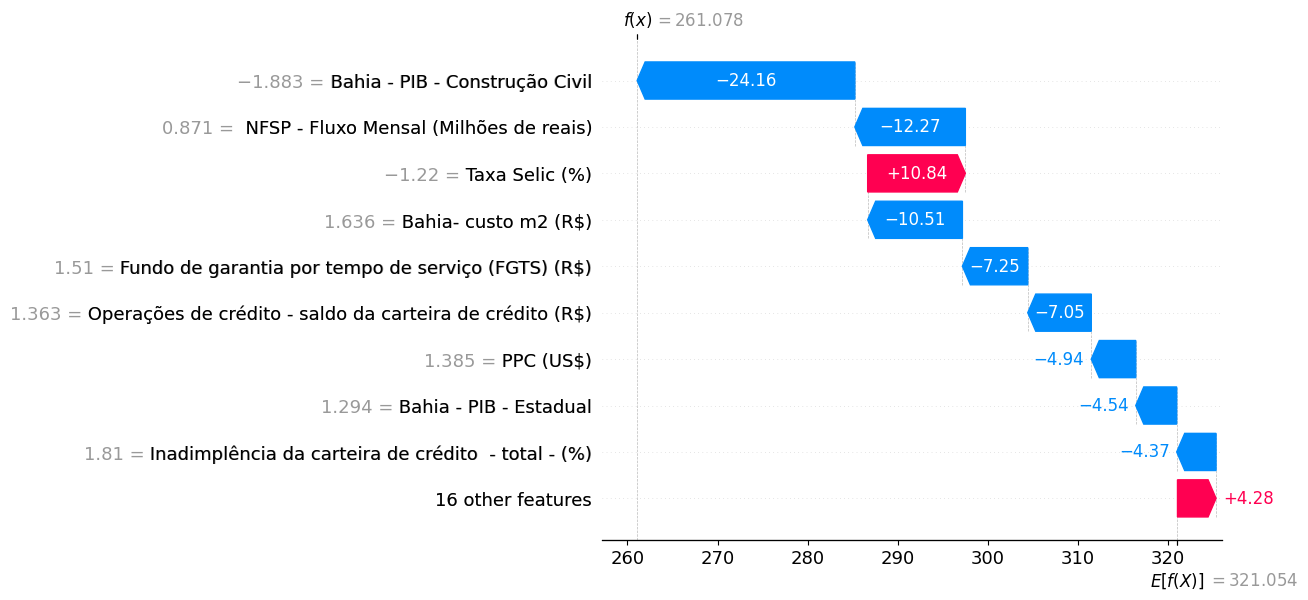

None

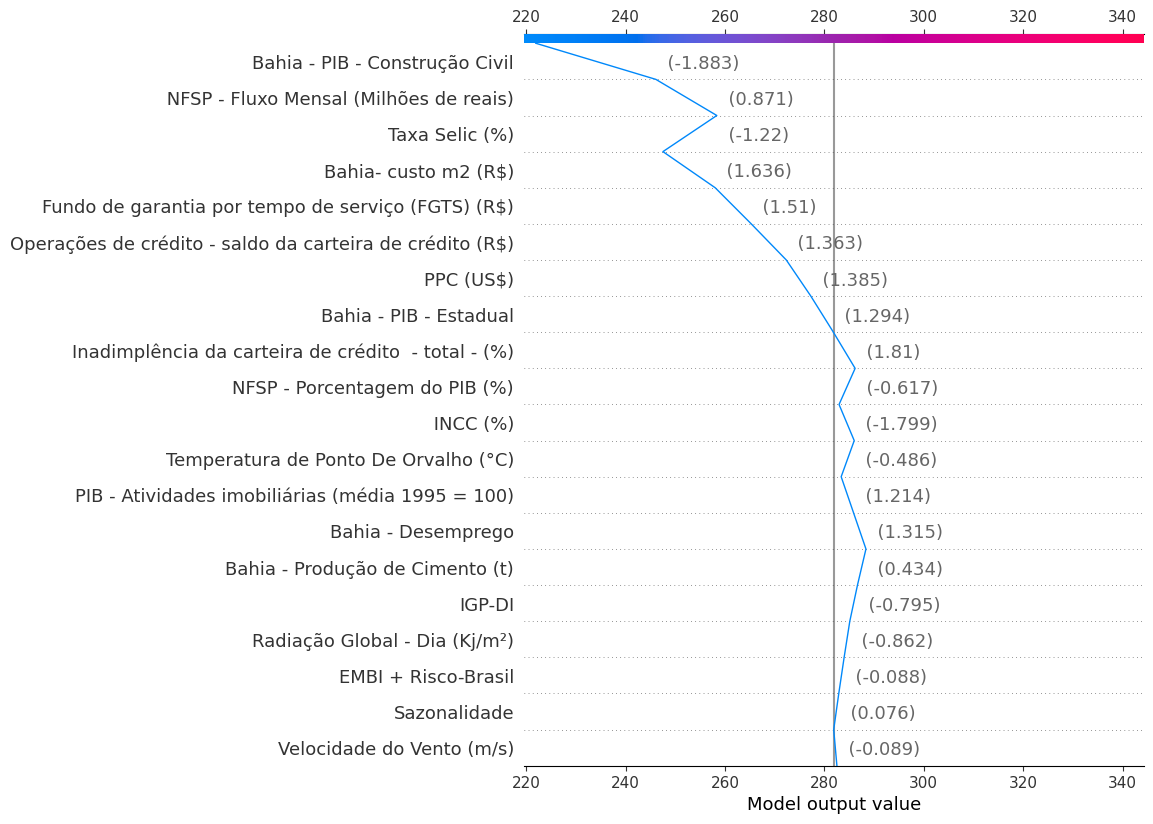

None

['Month-5', 261.07767, 281.912, 20.83432]

1/1 [==============================] - 0s 33ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 534us/step


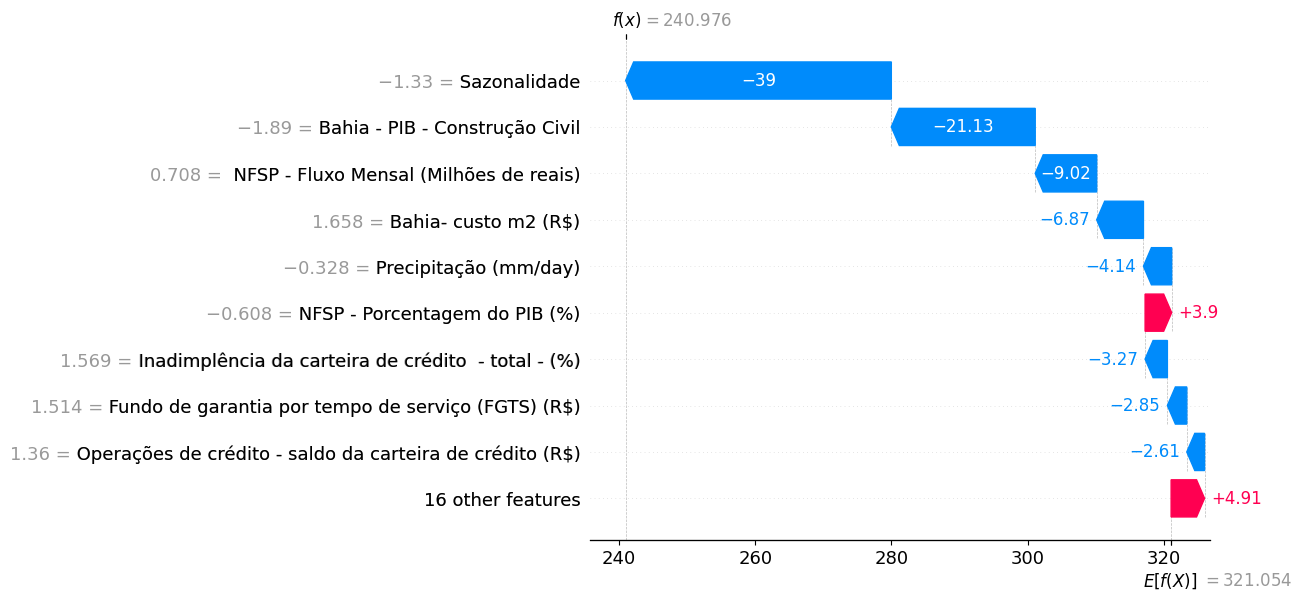

None

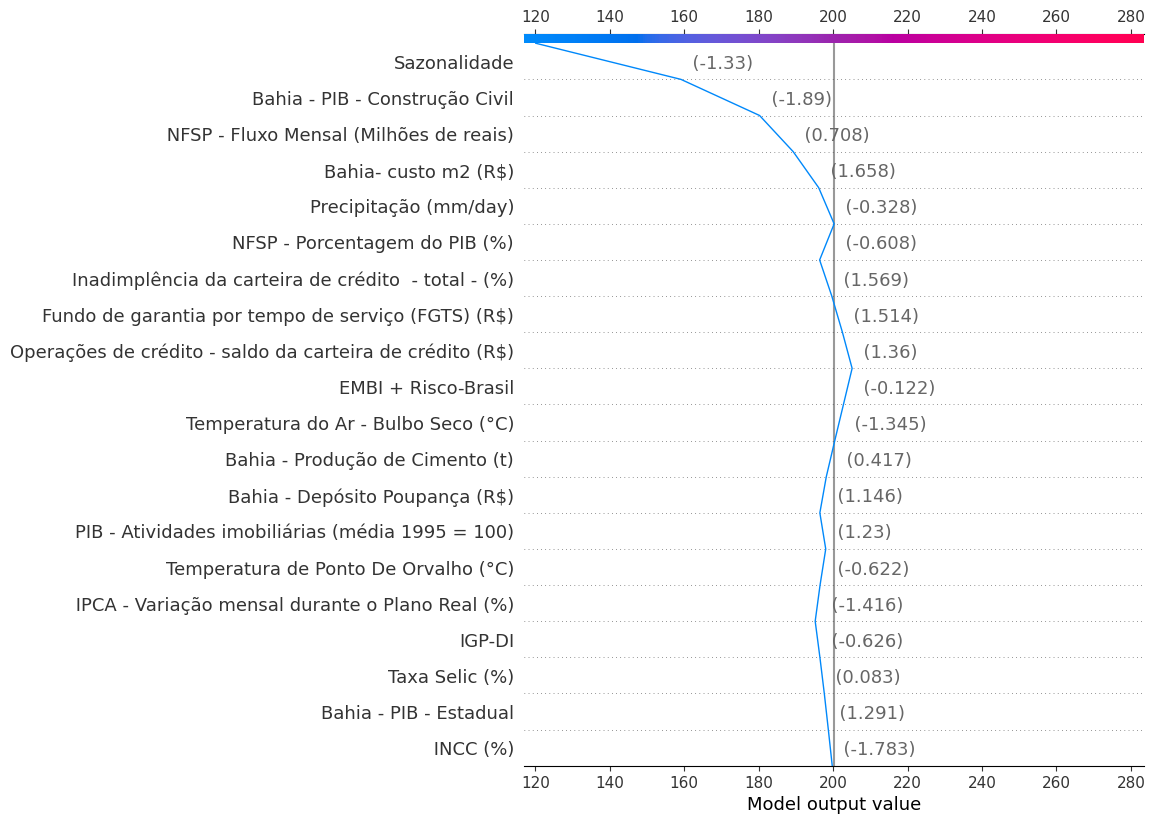

None

['Month-6', 240.97551, 200.213, 40.762512]

1/1 [==============================] - 0s 33ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 556us/step


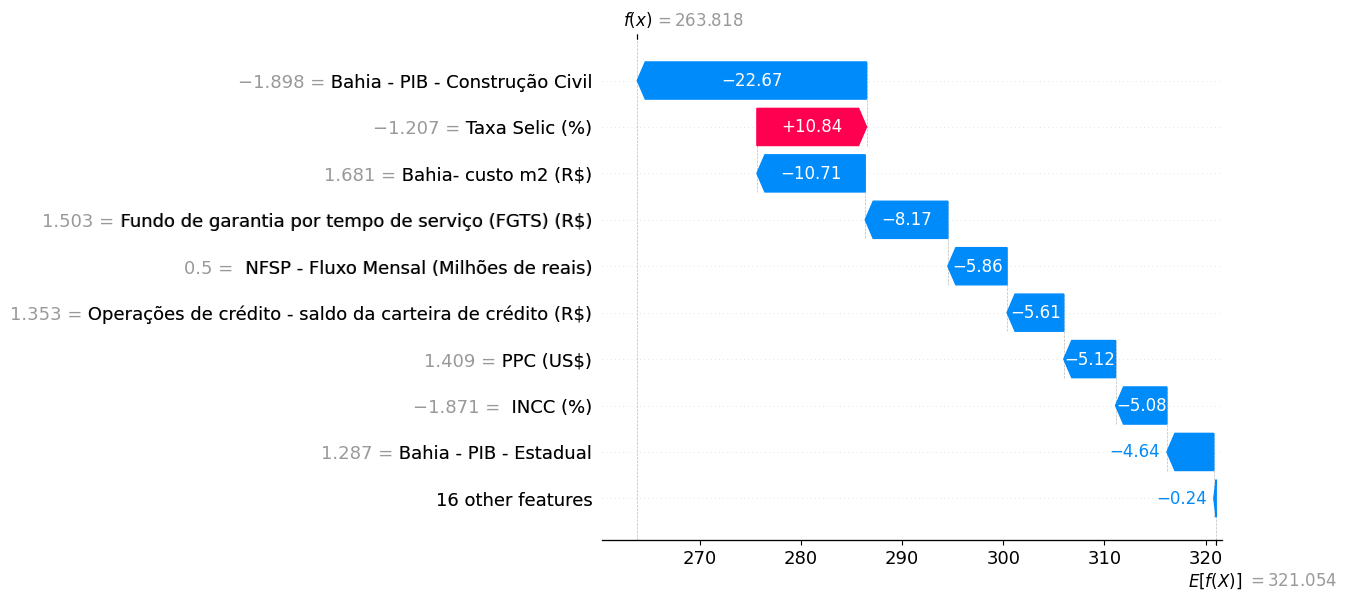

None

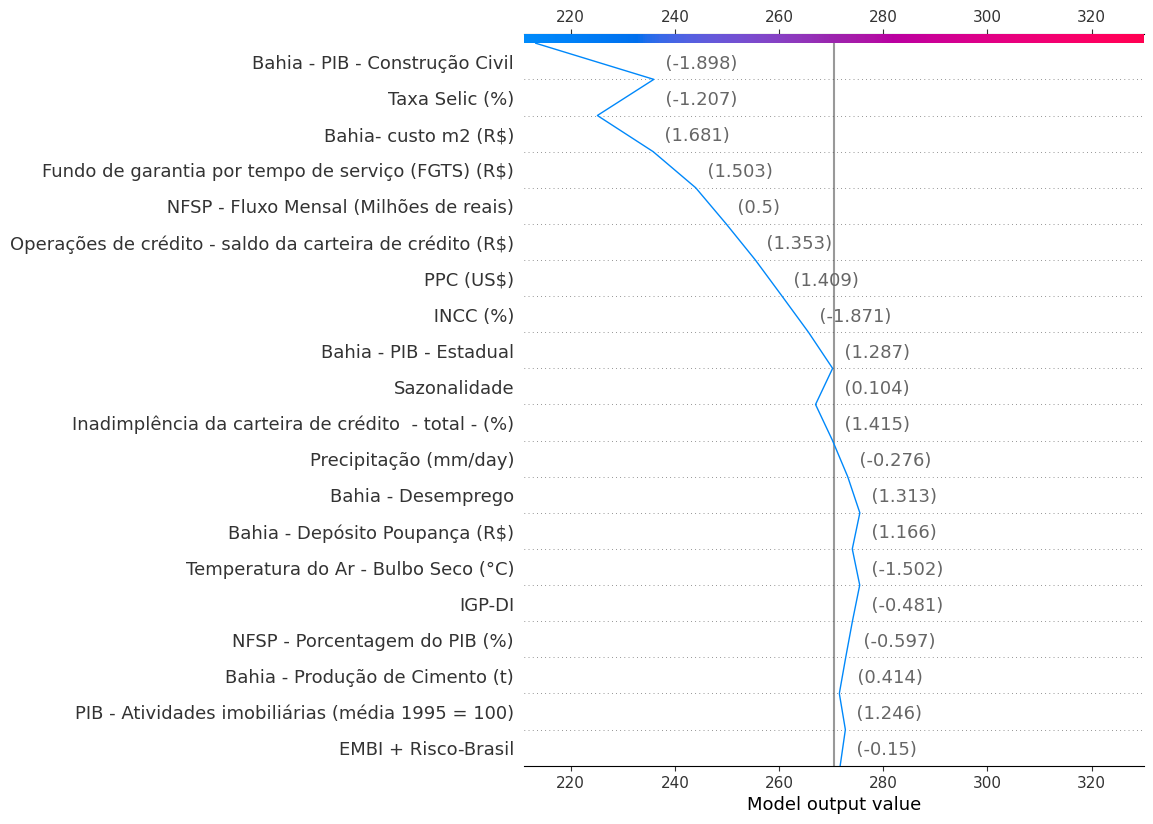

None

['Month-7', 263.81824, 270.511, 6.692749]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 546us/step


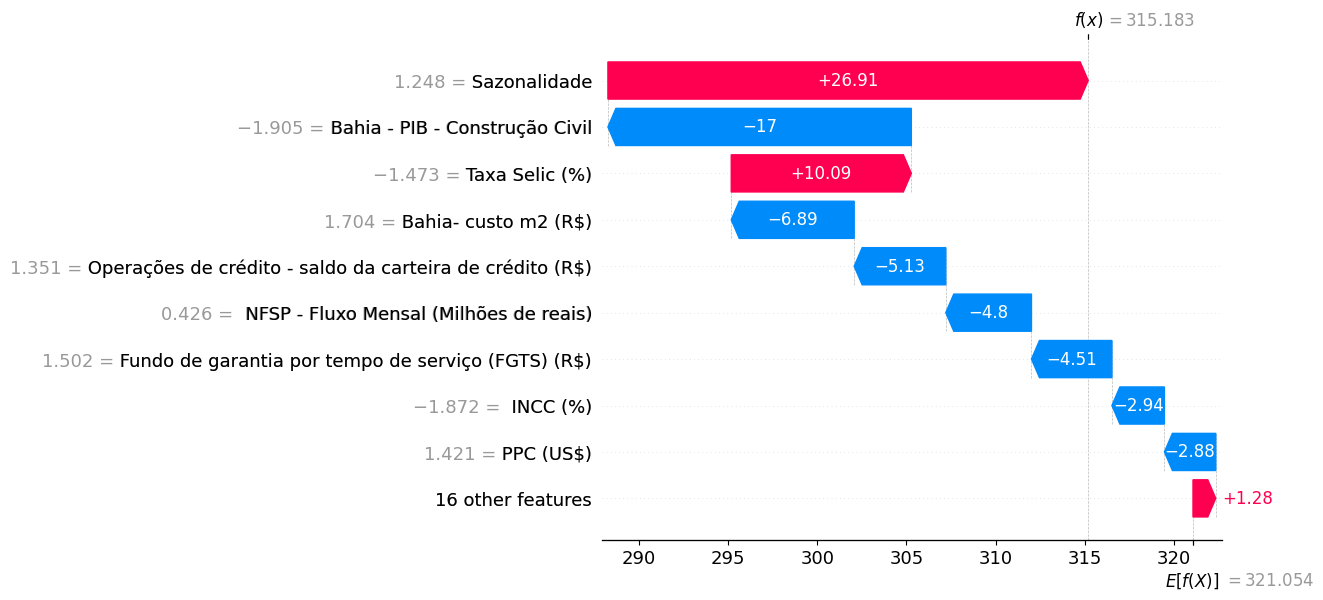

None

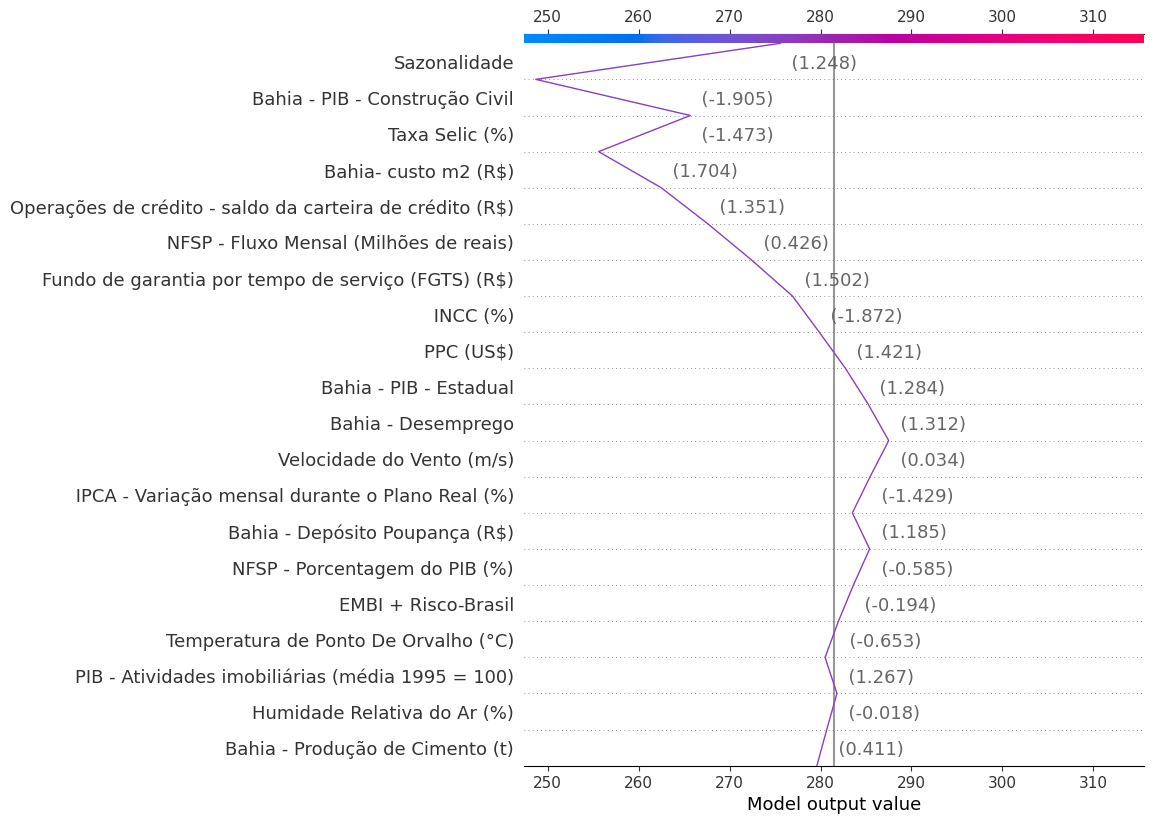

None

['Month-8', 315.18335, 281.466, 33.717346]

1/1 [==============================] - 0s 30ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 518us/step


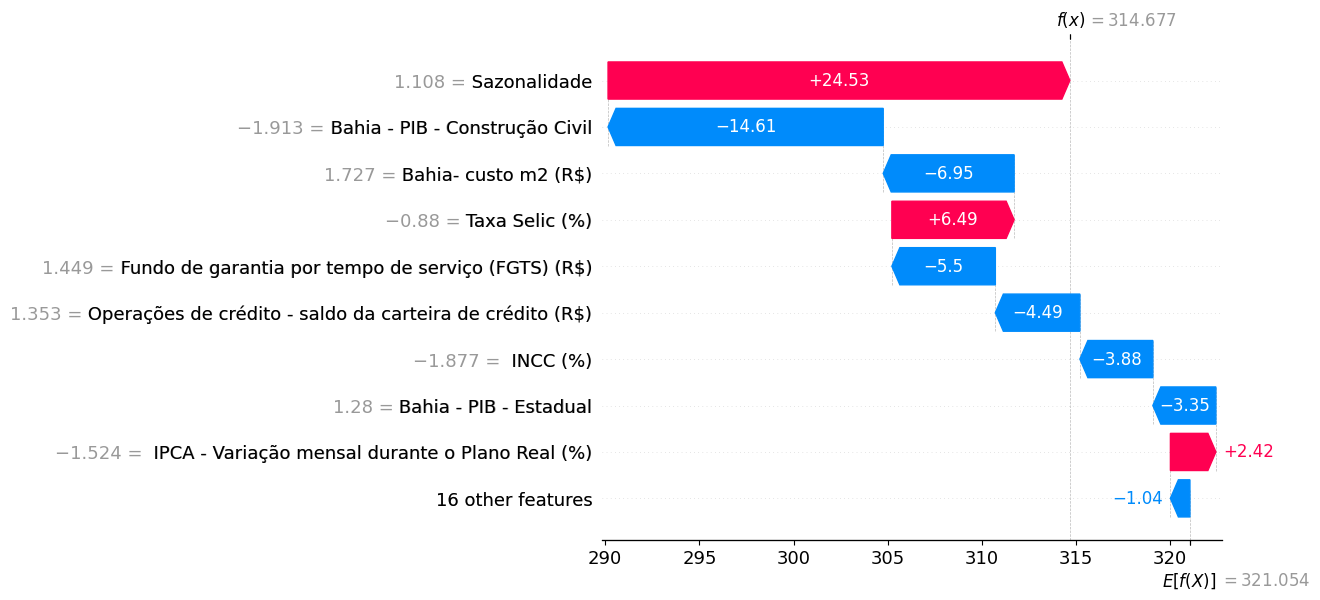

None

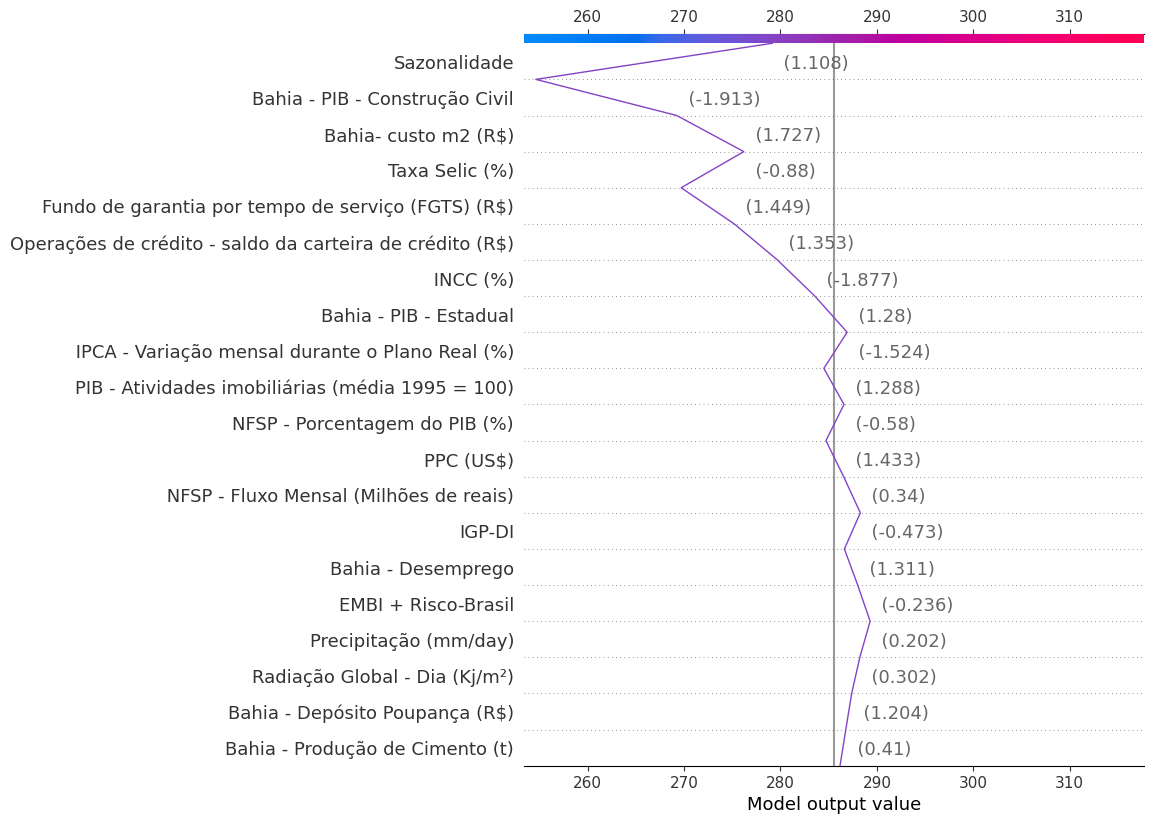

None

['Month-9', 314.67728, 285.535, 29.142273]

1/1 [==============================] - 0s 30ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 530us/step


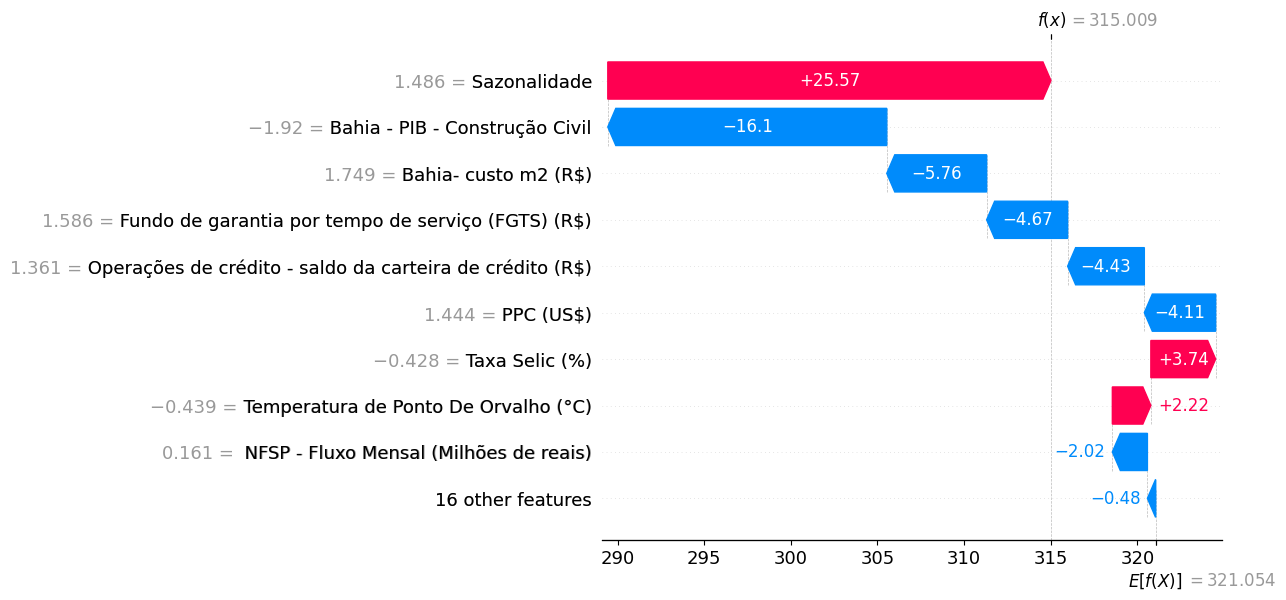

None

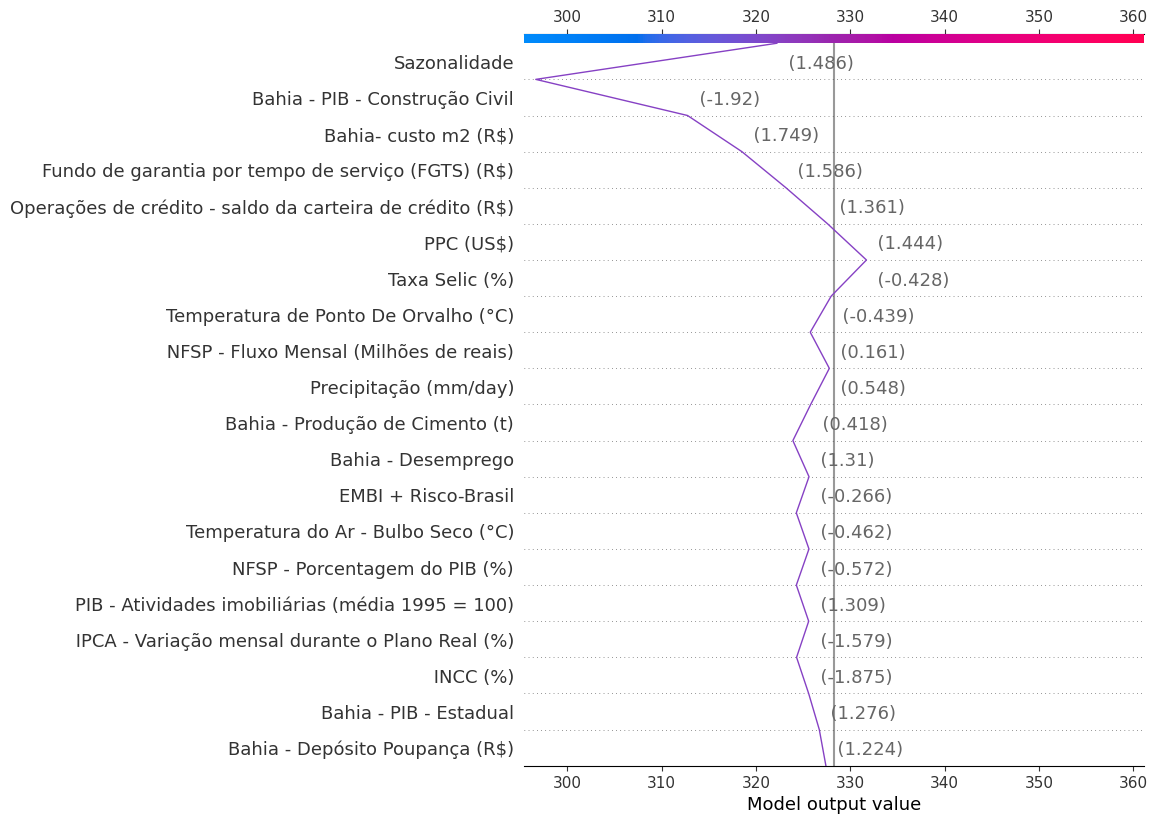

None

['Month-10', 315.00888, 328.259, 13.250122]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 548us/step


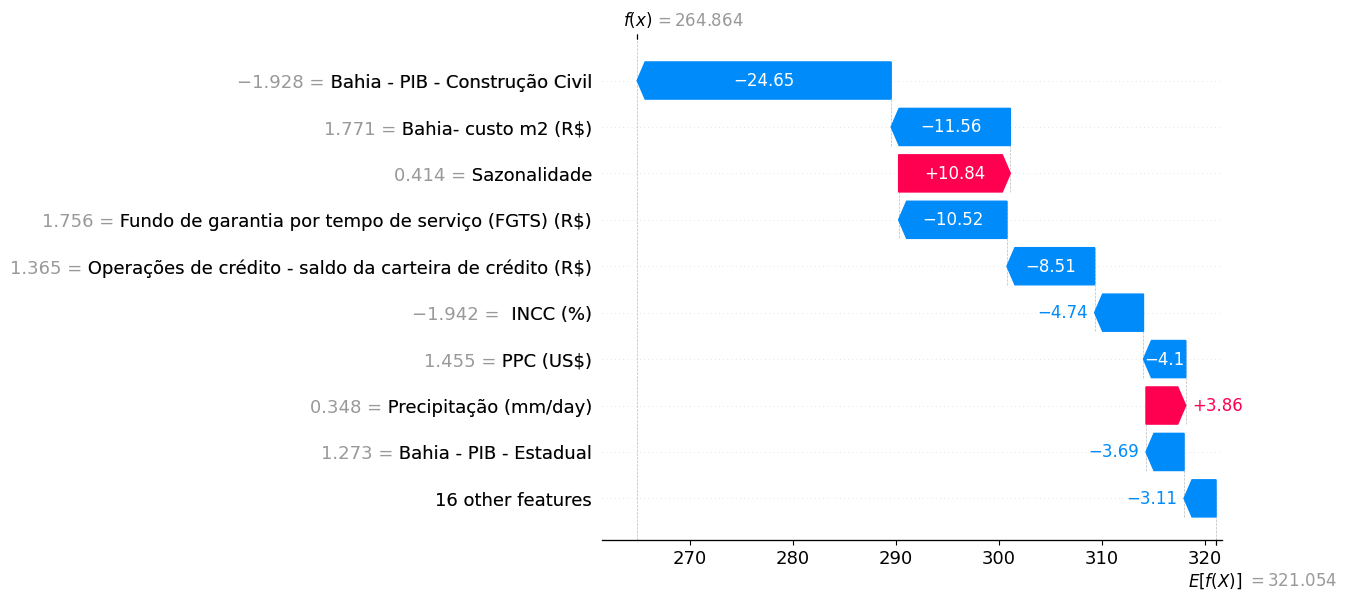

None

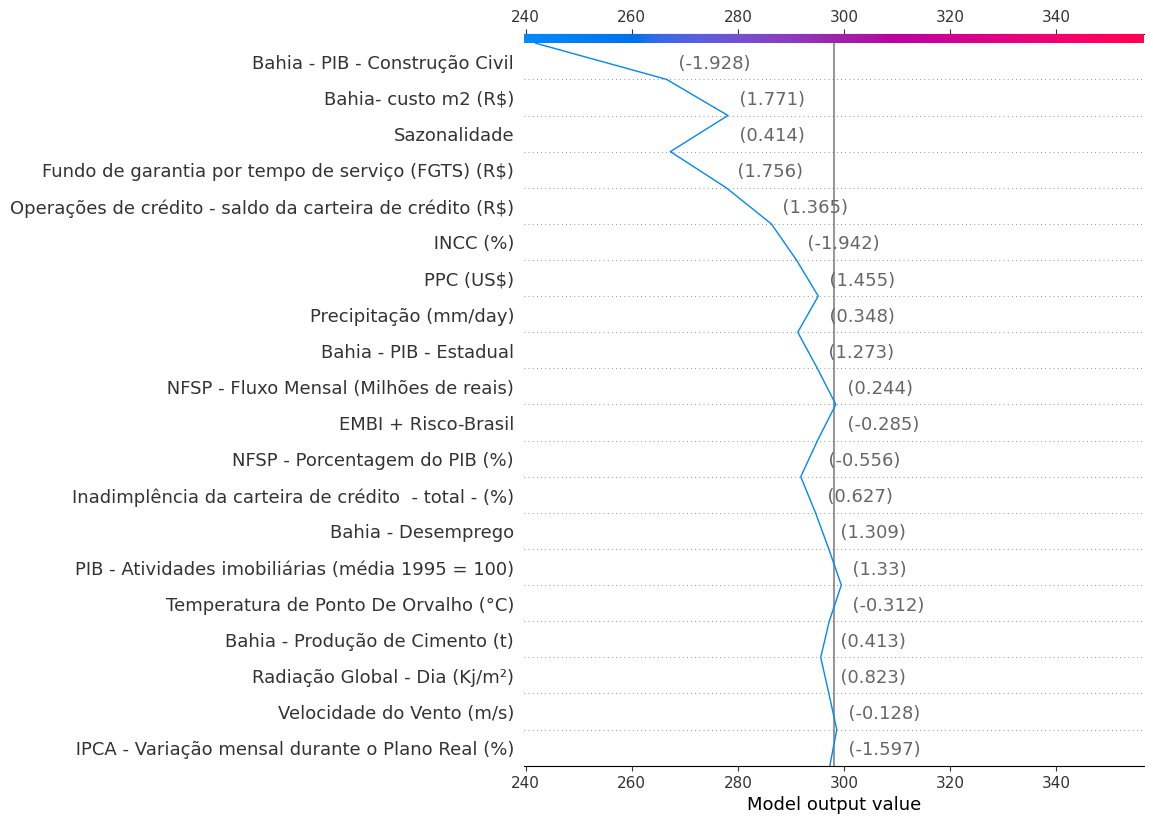

None

['Month-11', 264.86362, 298.078, 33.214386]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 516us/step


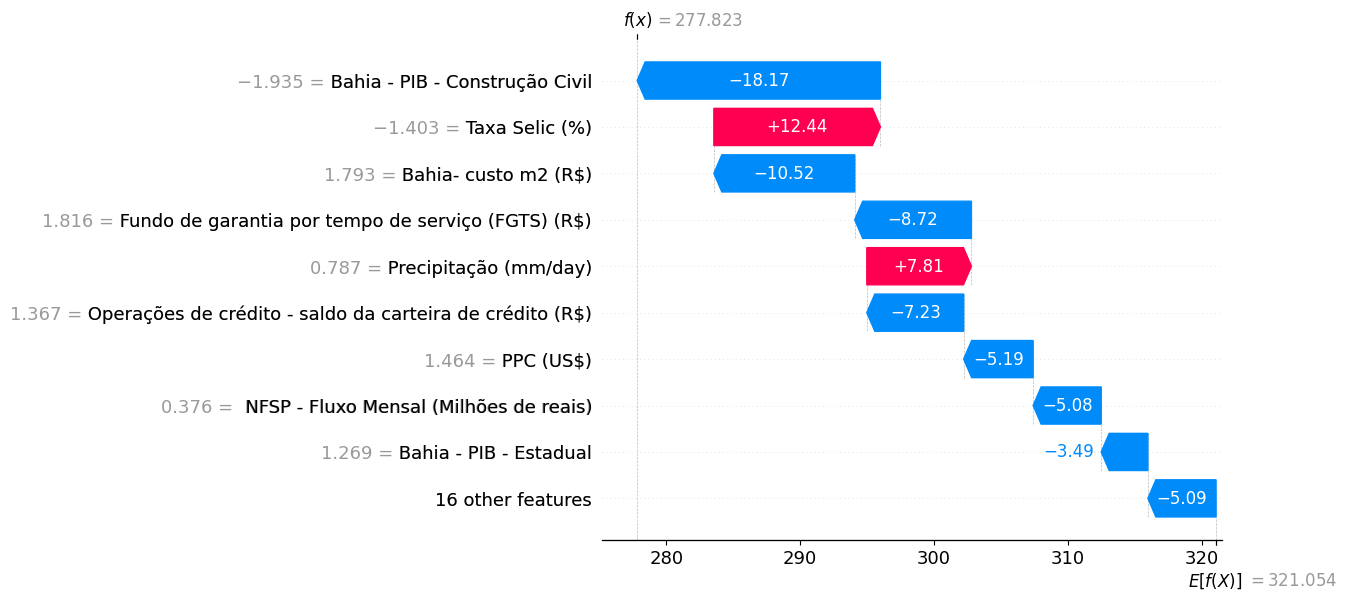

None

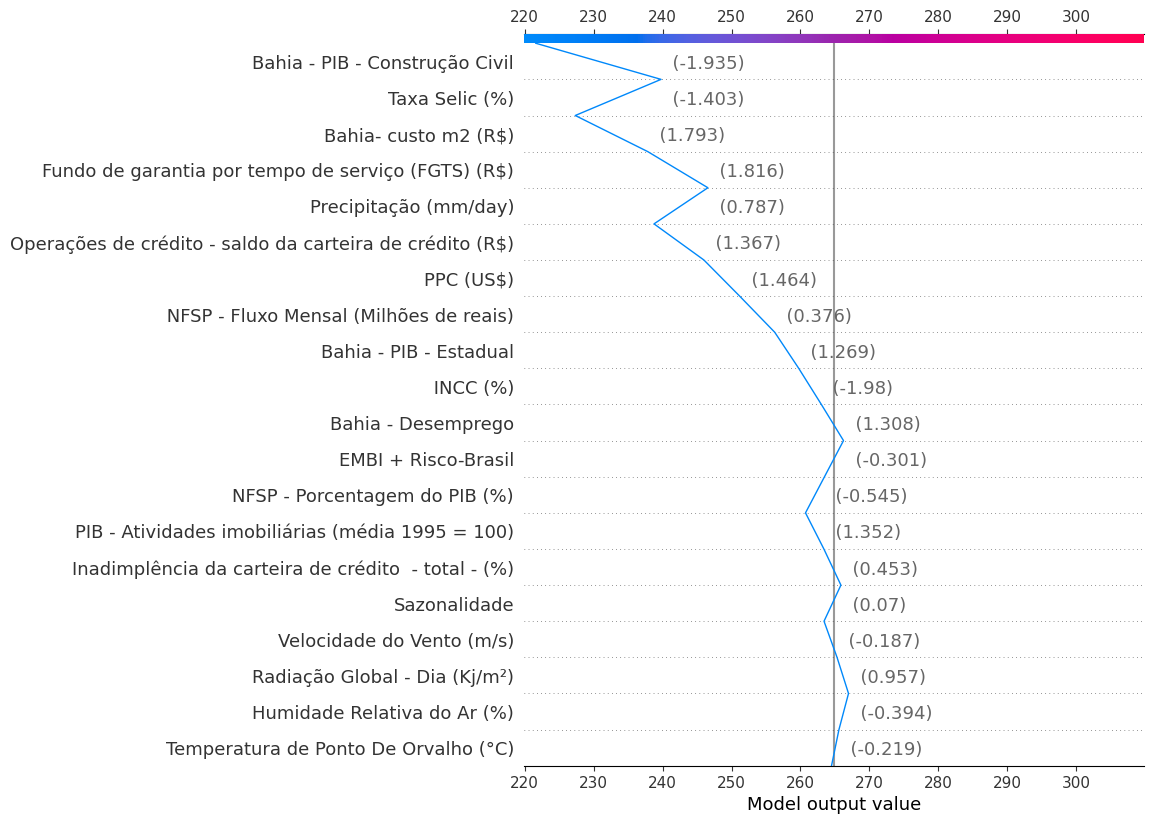

None

['Month-12', 277.82275, 264.838, 12.984741]

0           1          2           3           4   \
Month         Month-1     Month-2    Month-3     Month-4     Month-5   
Prediction  258.01416  240.974655  258.10611  240.980911  261.077667   
Target        291.428      249.43    241.612     252.303     281.912   
Error       33.413849    8.455338   16.49411   11.322083    20.83432   

                   5           6          7           8           9   \
Month         Month-6     Month-7    Month-8     Month-9    Month-10   
Prediction  240.97551  263.818237  315.18335  314.677277  315.008881   
Target        200.213     270.511    281.466     285.535     328.259   
Error       40.762512    6.692749  33.717346   29.142273   13.250122   

                    10          11  
Month         Month-11    Month-12  
Prediction  264.863617  277.822754  
Target         298.078     264.838  
Error        33.214386   12.984741

In [56]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            train_input,
                                            test_input, 
                                            test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

In [ ]:
display(mae)
display(mape)